## Лабораторная работа №3

выполнил: Формалёв Александр, 308Б-22

### Подготовка к работе

Импортируем необходимые библиотеки 

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from pylab import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX

Загружаем датасет

In [91]:
df = pd.read_csv("./train.csv", parse_dates=['Date'])
df.set_index('Date', inplace=True)
test_df = pd.read_csv('./test.csv', parse_dates=['Date'])
test_df.set_index('Date', inplace=True)

### Анализ данных

Рассмотрим общую прибыль каждого магазина

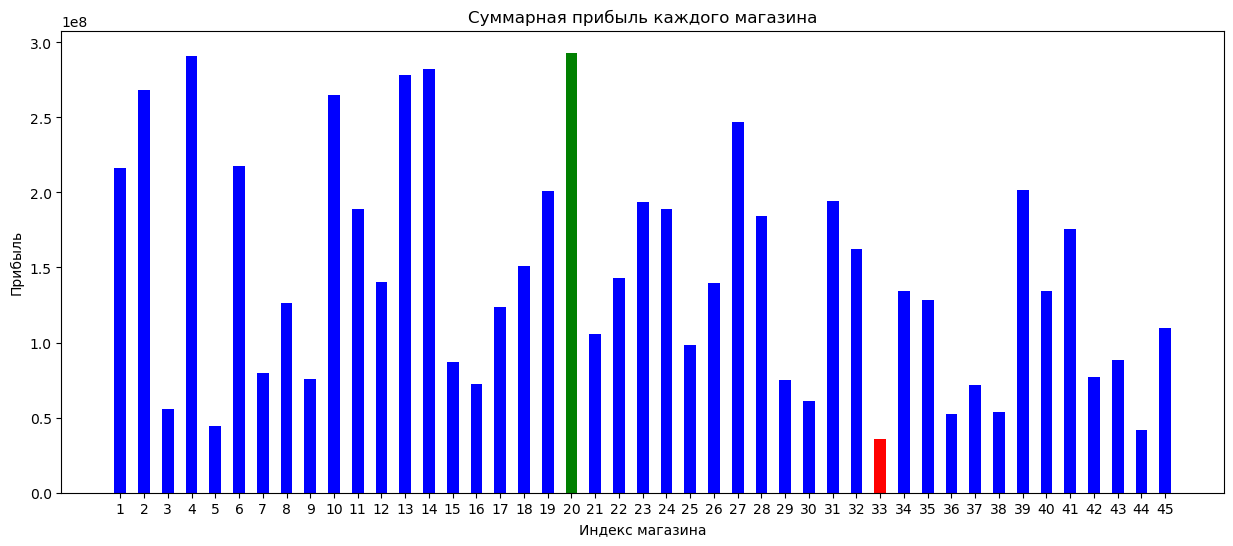

In [92]:
store_total_sales = df.groupby('Store')['Weekly_Sales'].sum().reset_index().rename(columns={'Weekly_Sales' : 'Total_Sales'})
max_profit_idx = store_total_sales['Total_Sales'].idxmax()
min_profit_idx = store_total_sales['Total_Sales'].idxmin()
colors = ['blue' if i != max_profit_idx and i != min_profit_idx else 'red' if i == min_profit_idx else 'green' for i in range(store_total_sales.shape[0])]
plt.figure(figsize=(15, 6))
plt.bar(store_total_sales['Store'], store_total_sales['Total_Sales'], width=0.5, color=colors)
plt.xticks(store_total_sales['Store'], rotation=0)
plt.xlabel('Индекс магазина')
plt.ylabel('Прибыль')
plt.title('Суммарная прибыль каждого магазина')
plt.show()

На диаграмме видно, что наибольшую общую прибыль имеет 20-й магазин, а наименьшую - 33. Теперь рассмотрим прибыль этих магазинов по неделям.

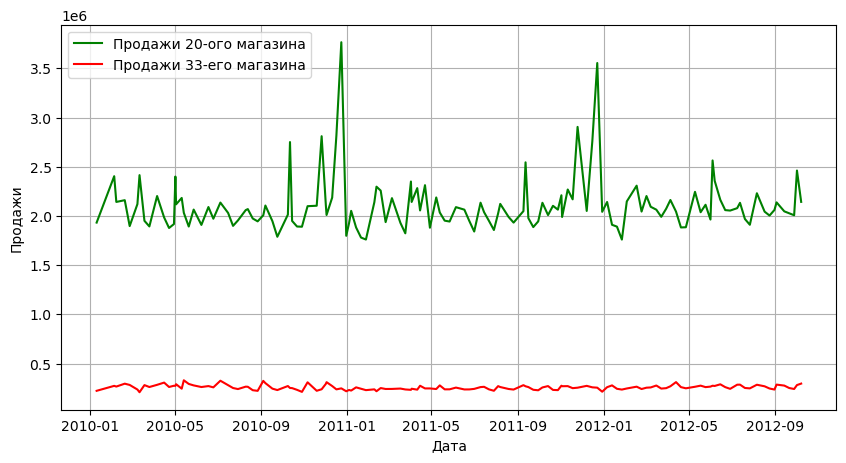

In [93]:
sales_max = df[df['Store'] == 20][['Weekly_Sales']].reset_index()
sales_min = df[df['Store'] == 33][['Weekly_Sales']].reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(x='Date', y='Weekly_Sales', data=sales_max, color='green', label='Продажи 20-ого магазина')
sns.lineplot(x='Date', y='Weekly_Sales', data=sales_min, color='red', label='Продажи 33-его магазина')
plt.xlabel("Дата")
plt.ylabel('Продажи')
plt.legend()
plt.grid(True)
plt.show()

Можно заметить, что у абсолютно разных по выручке магазинов имелись сильные скачки продаж в конце 2010-ого года. (Только после построения всех этих диаграмм я понял, что это было бесполезно. Оставляю, чтобы похвастаться, что я это сделал :) )

Проверим стационарность

In [50]:
def adf_test(series):
    res = adfuller(series)
    return res[1]
p_vals = df.groupby('Store')['Weekly_Sales'].apply(adf_test)
unstationary_stores = [store for store, p_val in p_vals.items() if p_val >= 0.05]
print(unstationary_stores)

[33, 36, 38, 43, 44]


STL-декомпозиция ряда

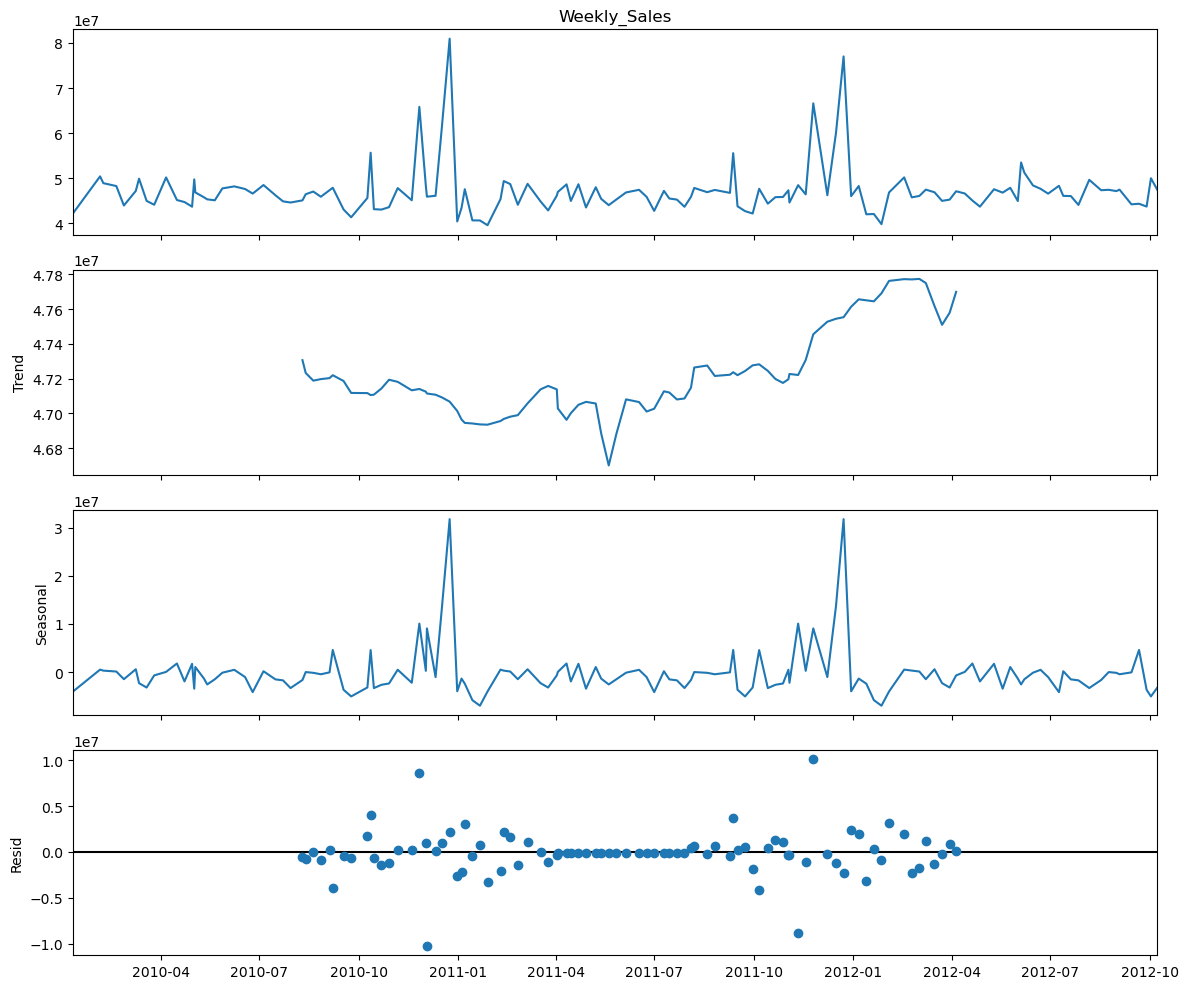

In [ ]:
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum()
plt.rcParams["figure.figsize"] = 12, 10
decompose = seasonal_decompose(weekly_sales, model='additive', period=12)
decompose.plot()

plt.show()

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

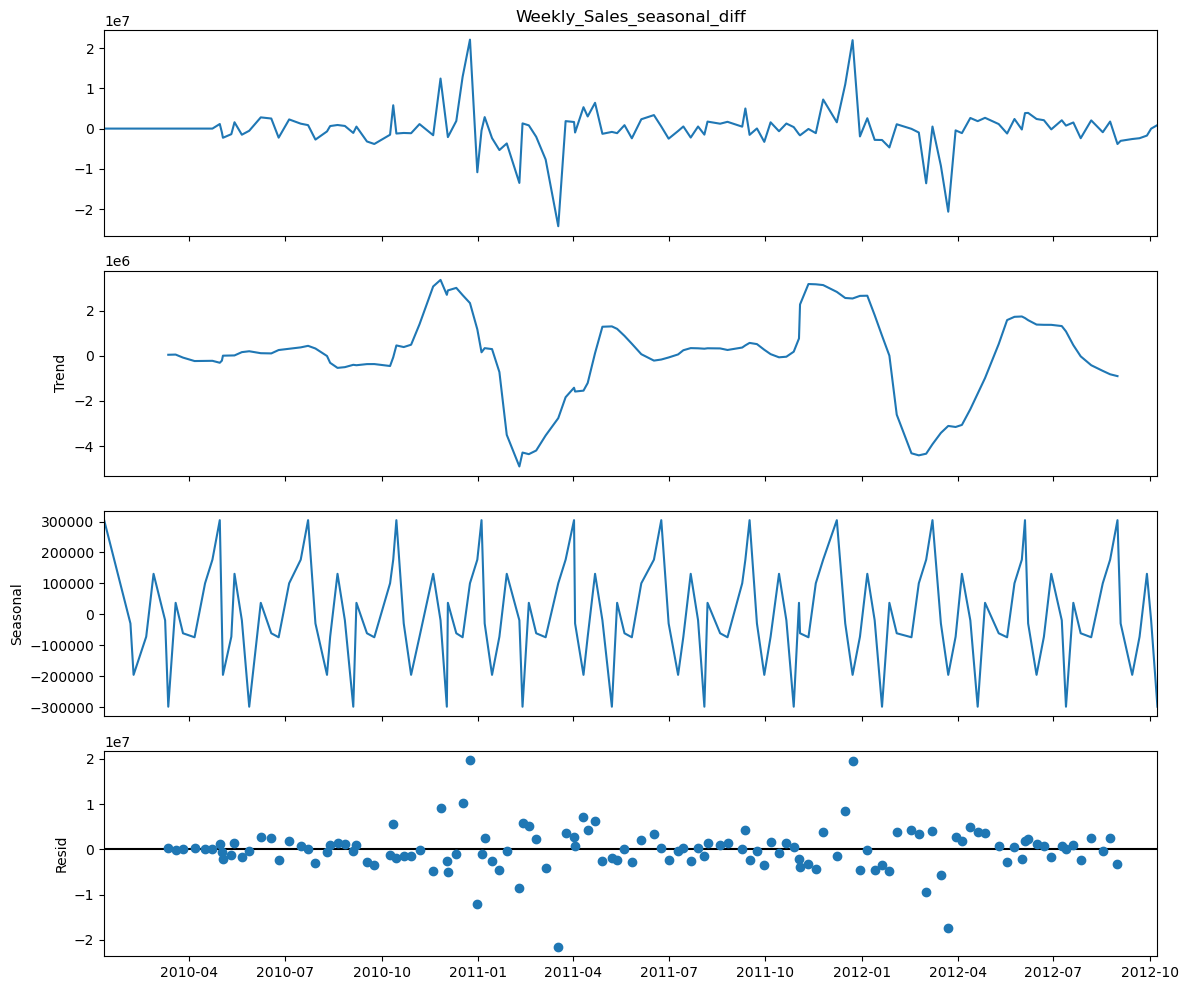

[]


In [74]:
def seasonal_difference(df):
    df['Weekly_Sales_seasonal_diff'] = df['Weekly_Sales'].diff(12)
    return df
df = df.groupby('Store', group_keys=False).apply(seasonal_difference)

weekly_sales = df.groupby('Date')['Weekly_Sales_seasonal_diff'].apply(lambda x: x.iloc[13:].sum())
plt.rcParams["figure.figsize"] = 12, 10
decompose = seasonal_decompose(weekly_sales, model='additive', period=12)
decompose.plot()

plt.show()

p_vals = df.groupby('Store')['Weekly_Sales_seasonal_diff'].apply(lambda x: adf_test(x[13:]))
unstationary_stores = [store for store, p_val in p_vals.items() if p_val >= 0.05]
print(unstationary_stores)

Мы избавились от тренда и все ряды стали стационарными.

### Выбор модели и обучение

Рассмотрим ACF и PACF полученного ряда:

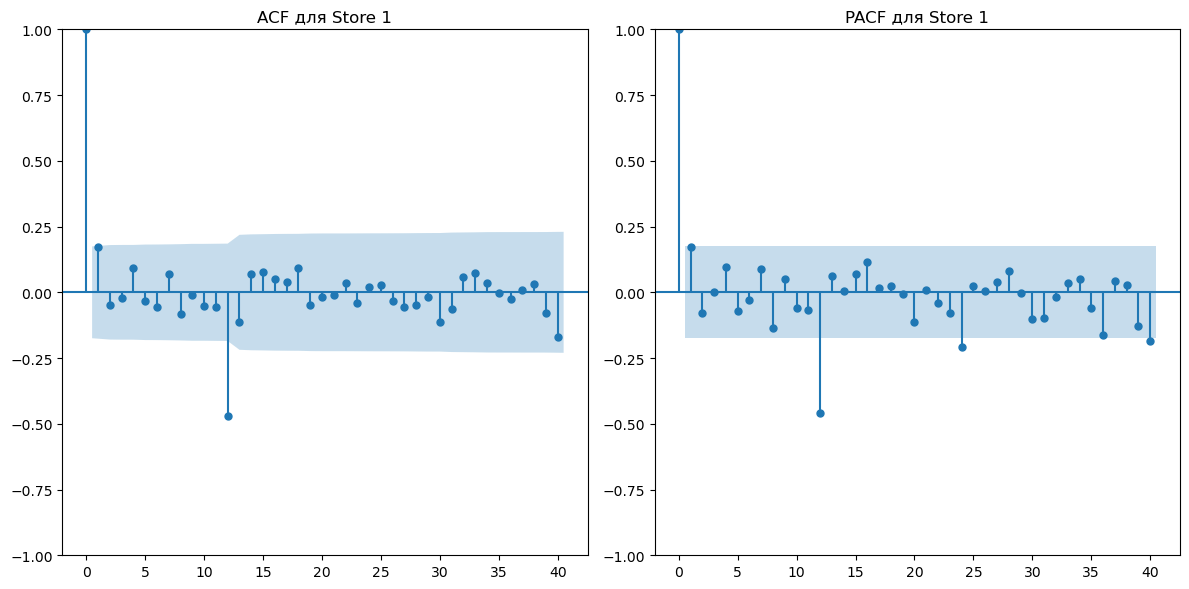

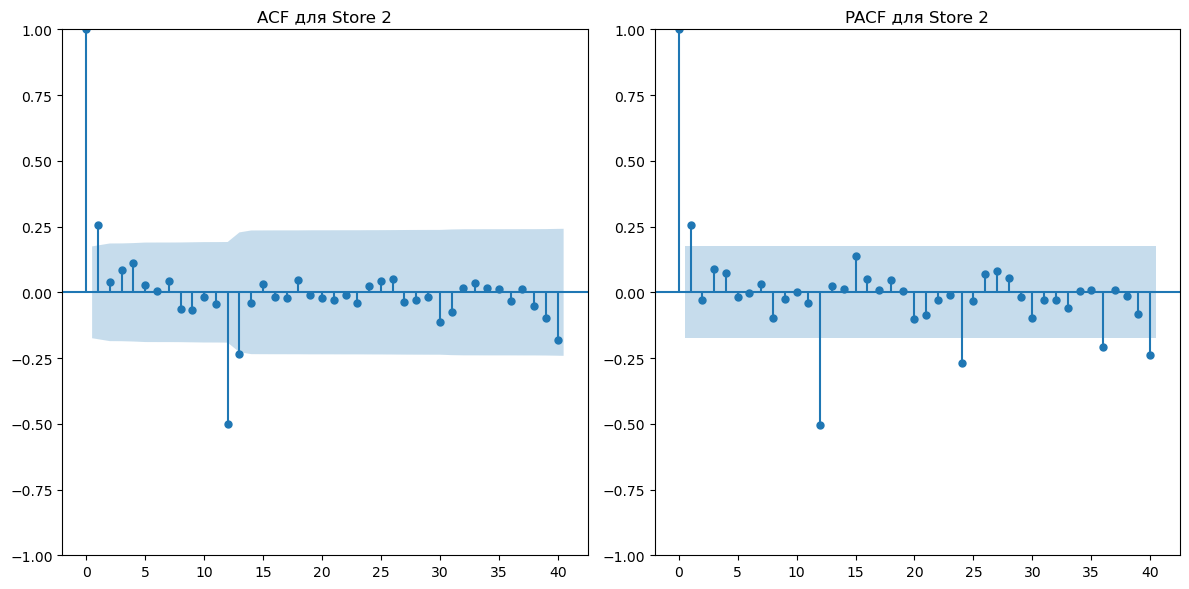

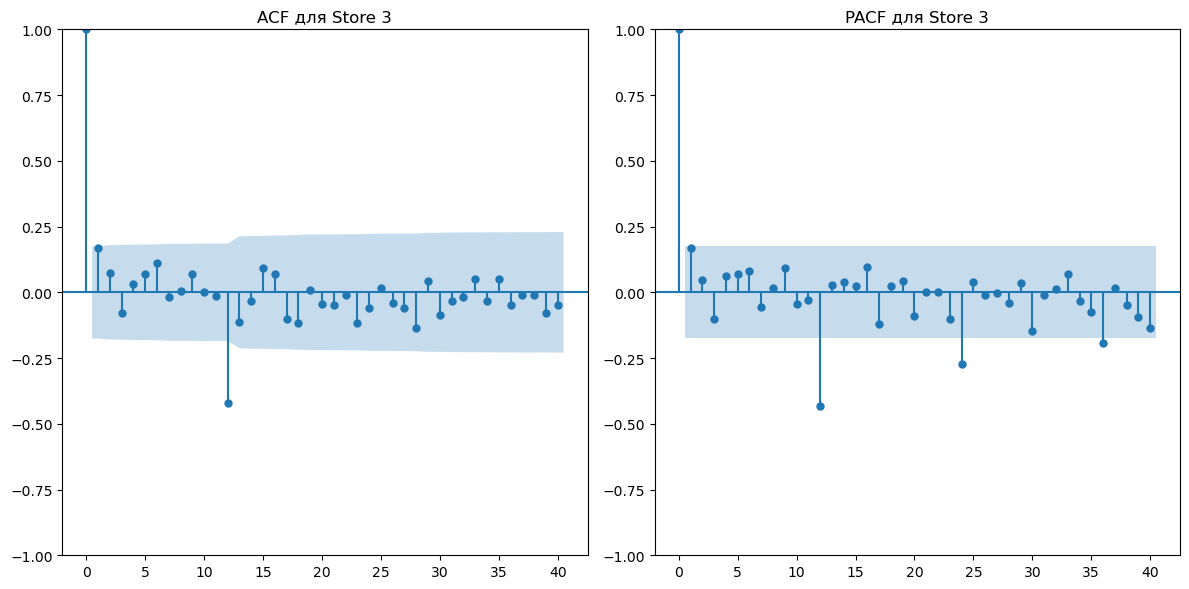

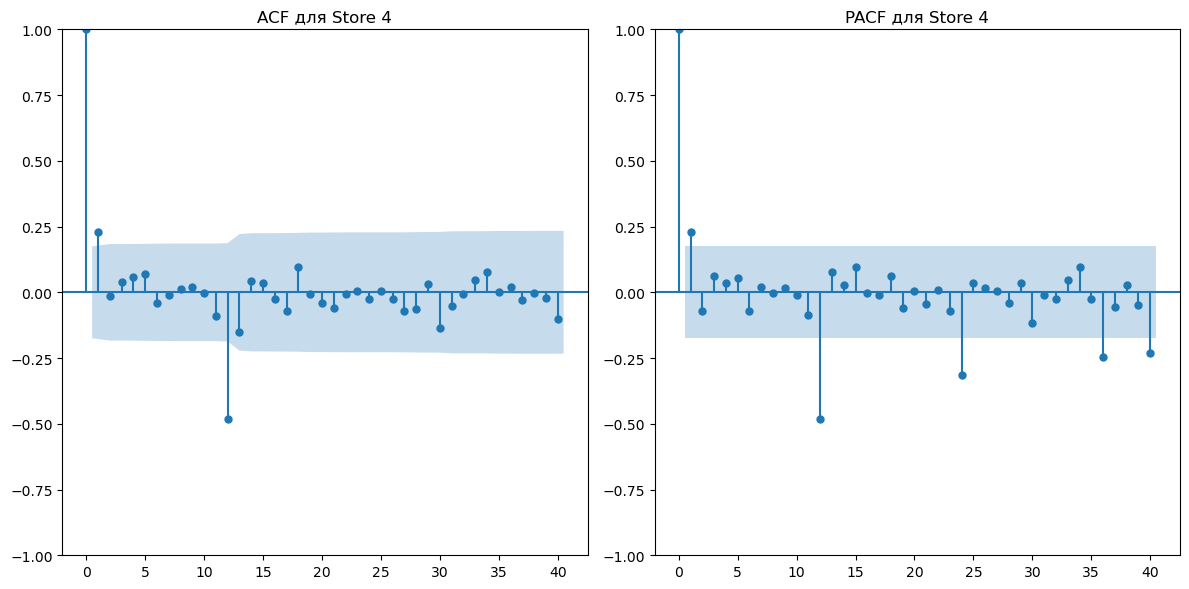

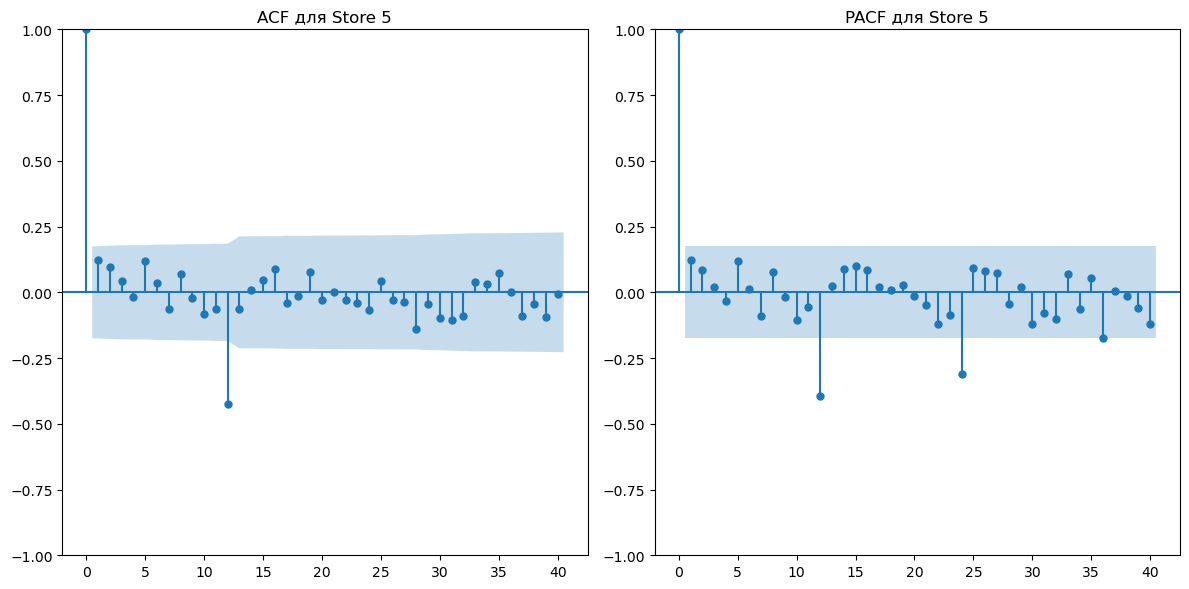

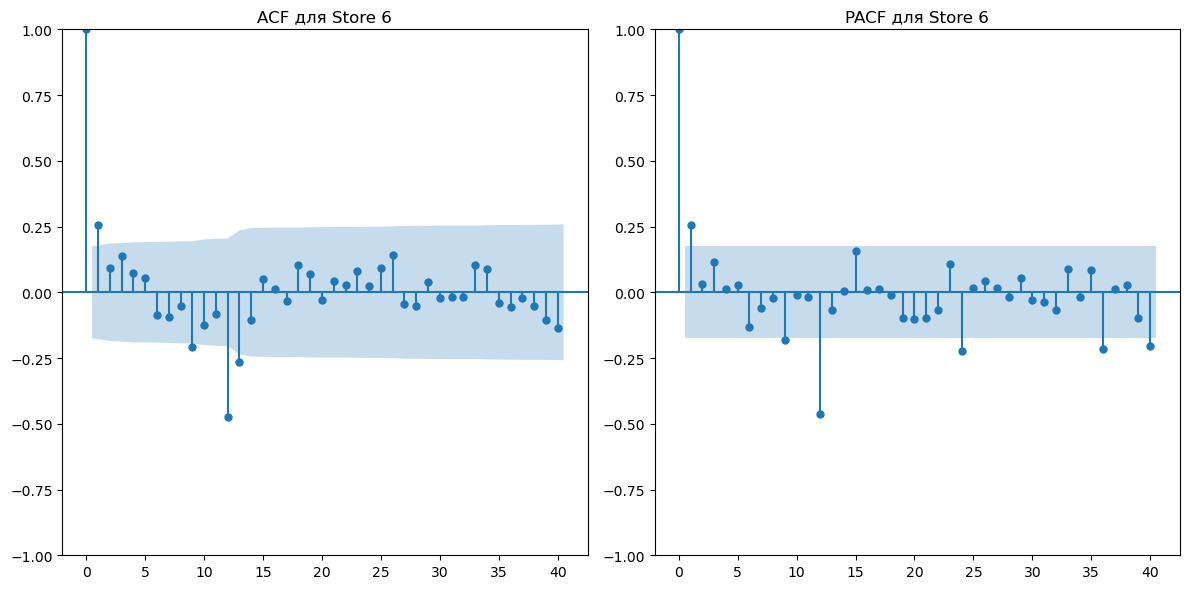

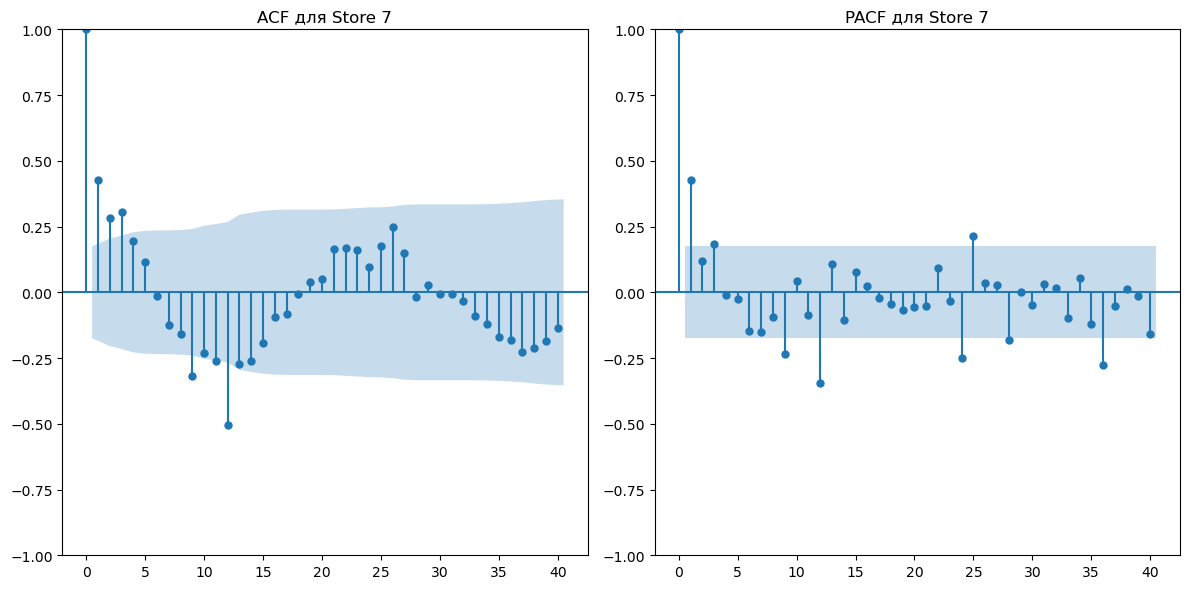

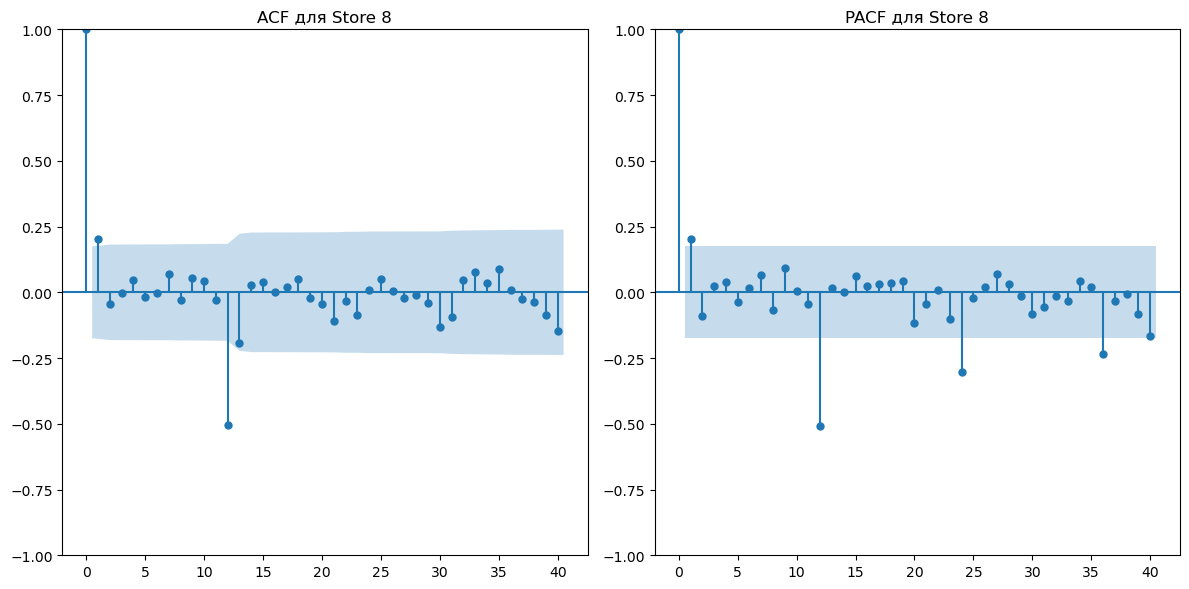

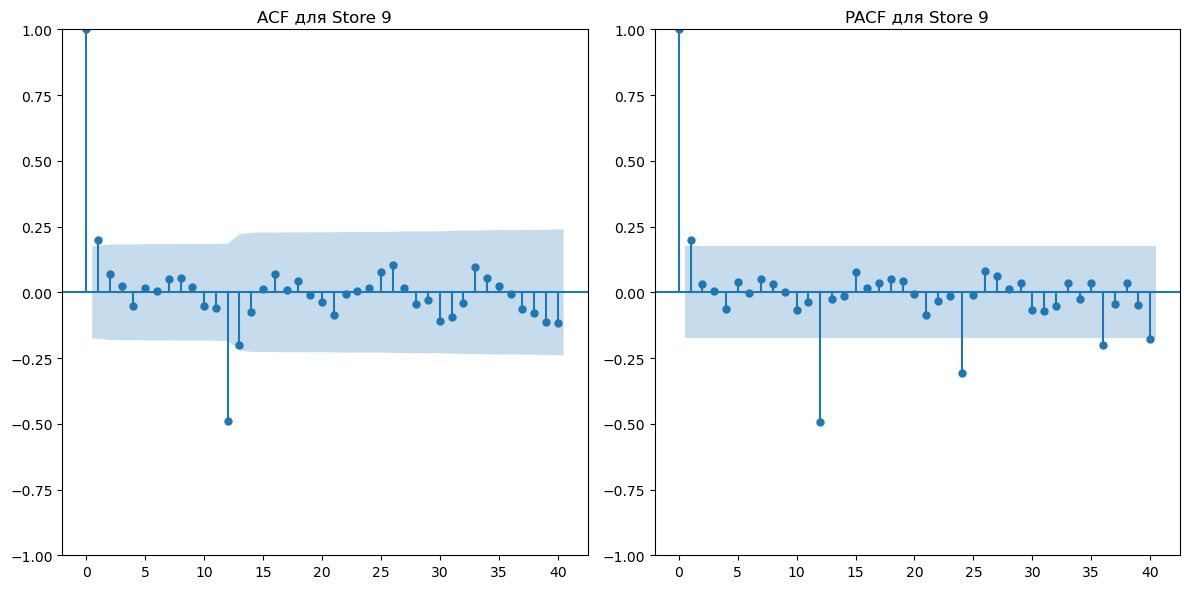

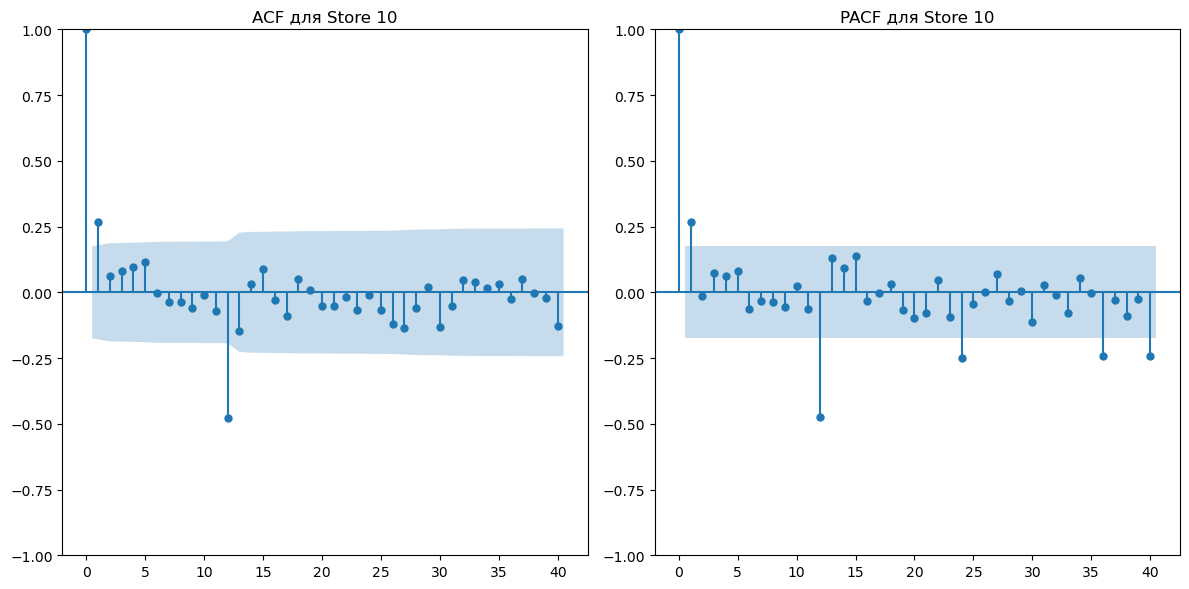

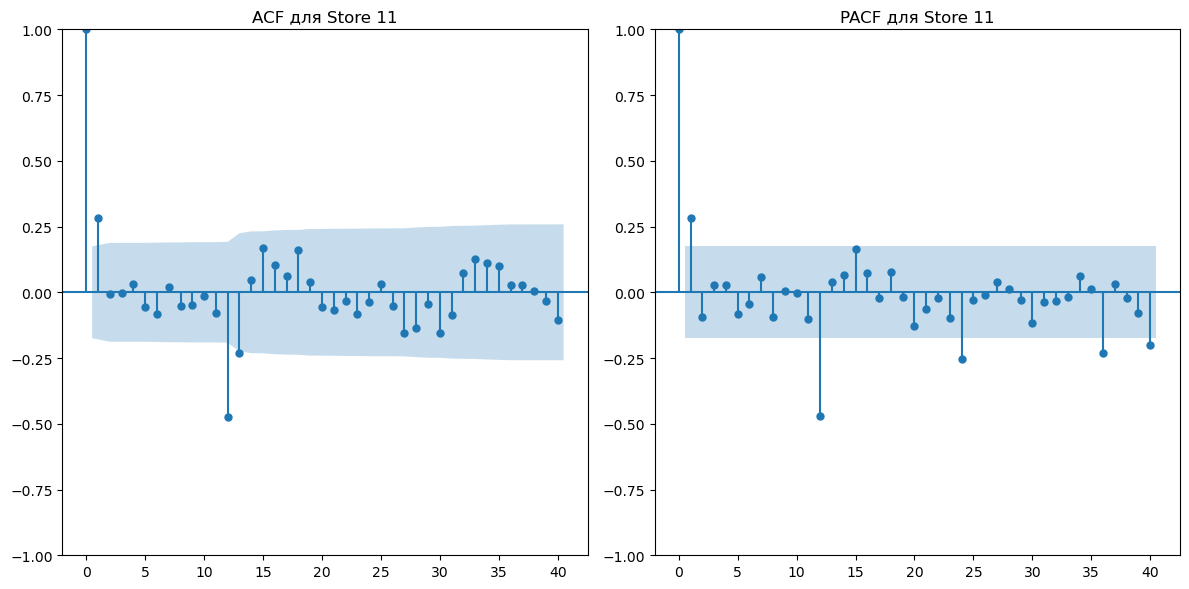

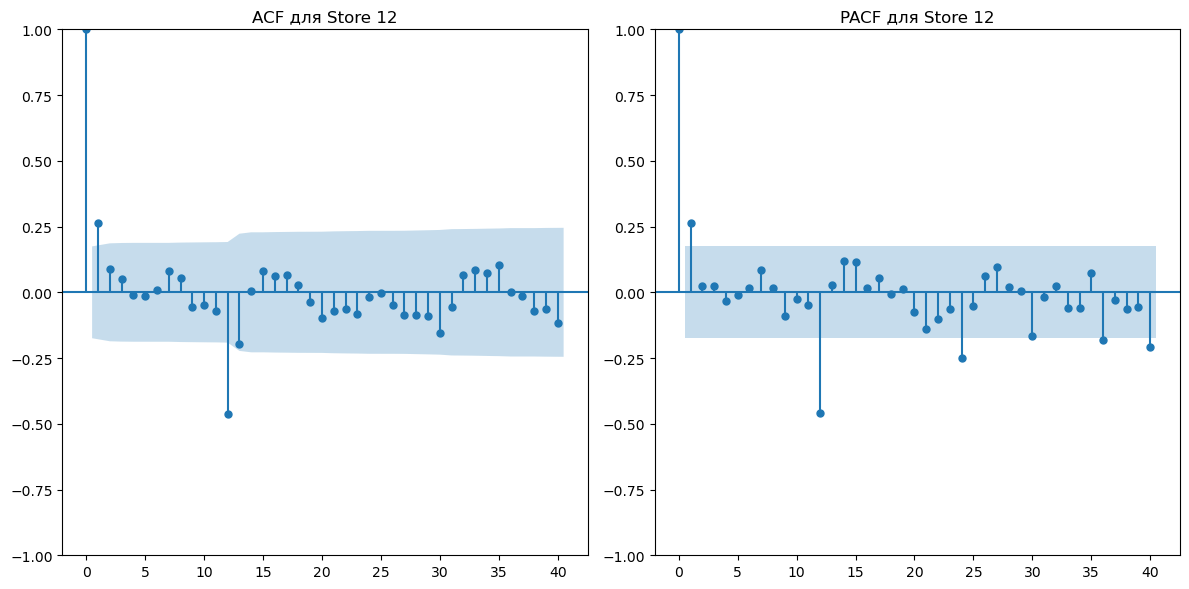

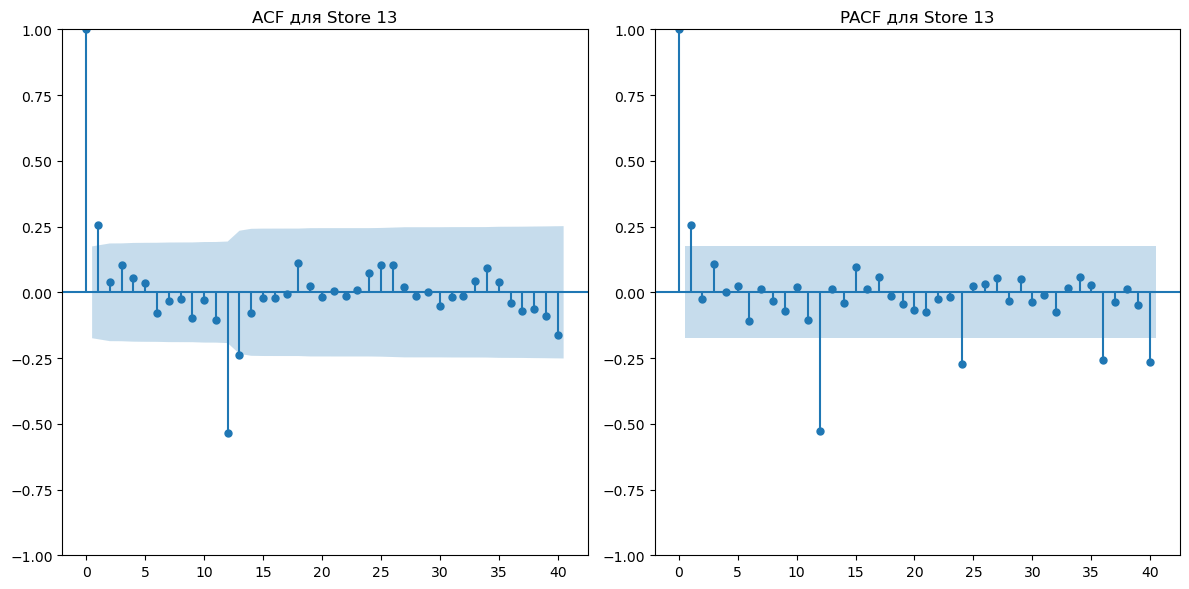

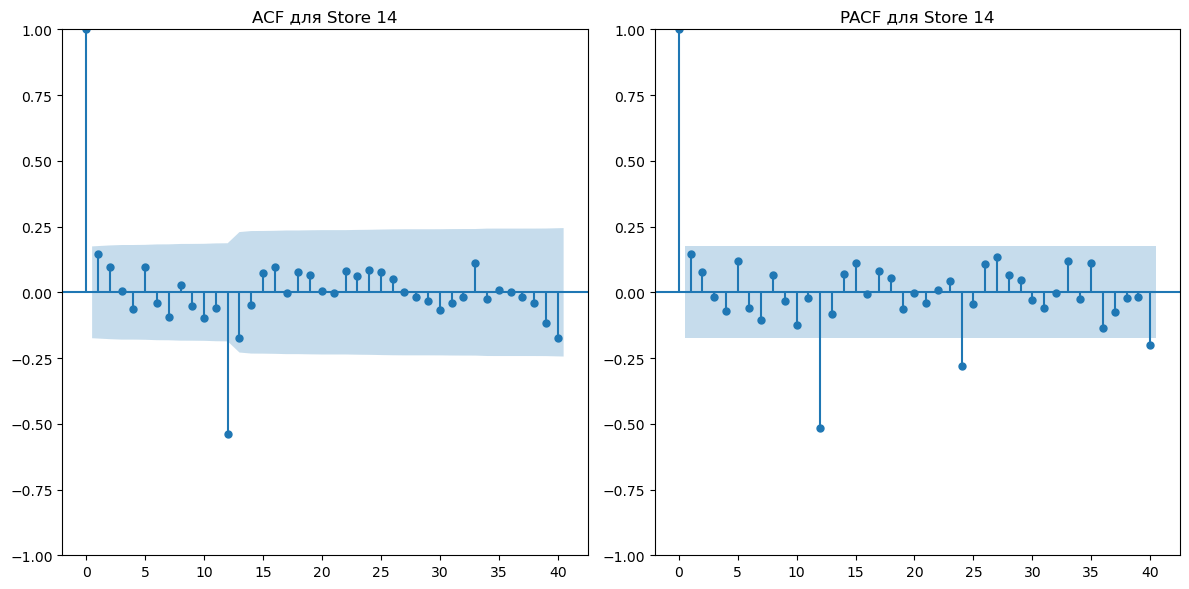

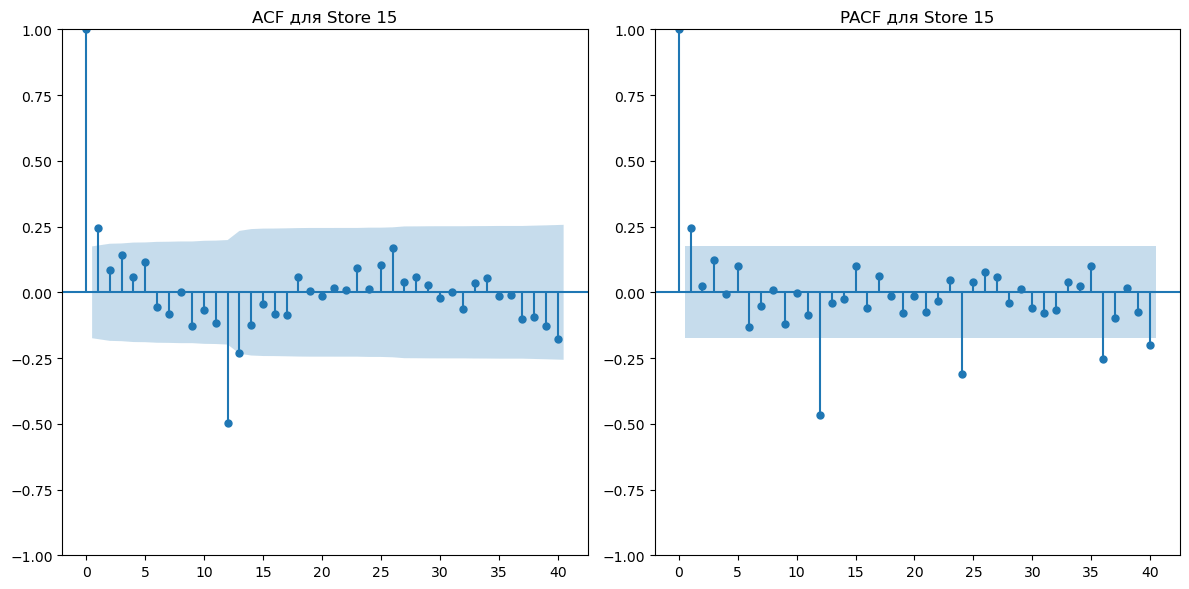

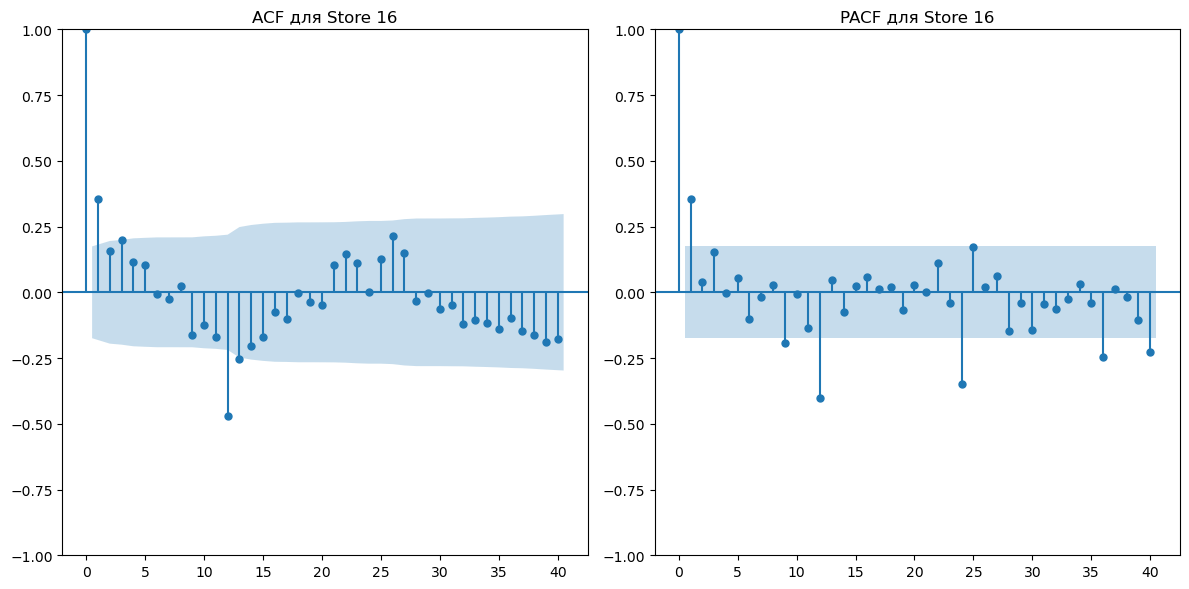

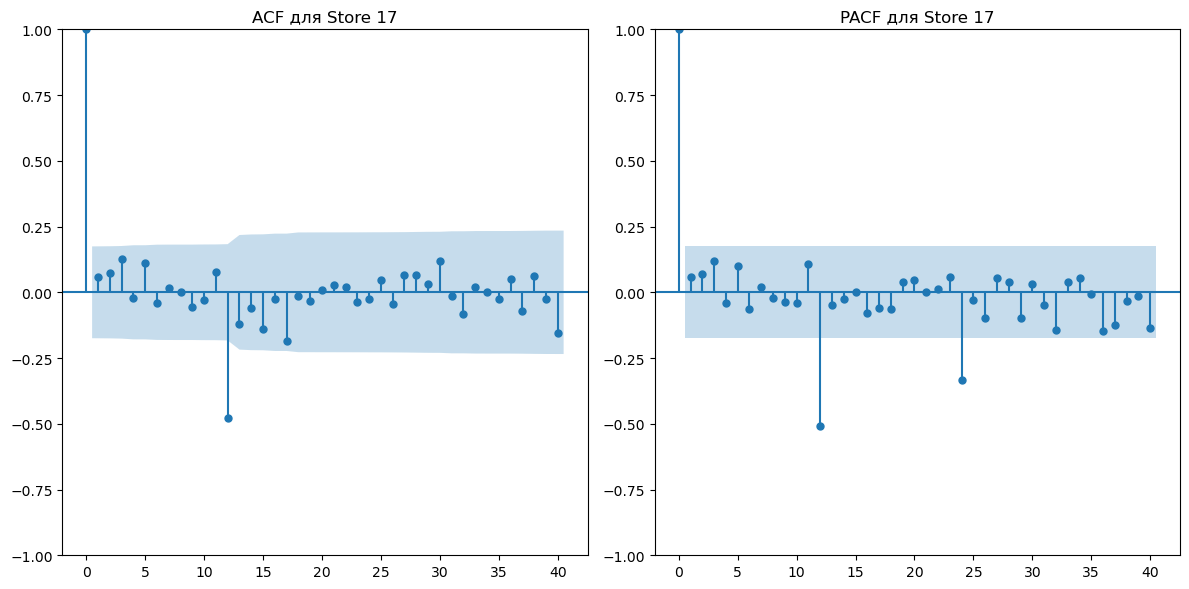

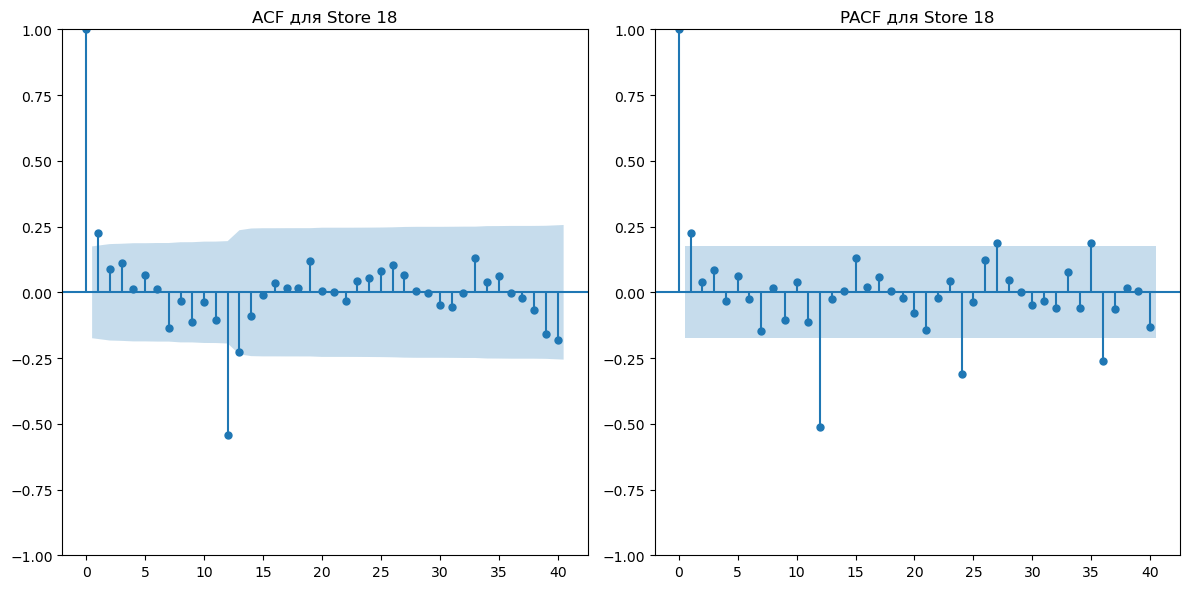

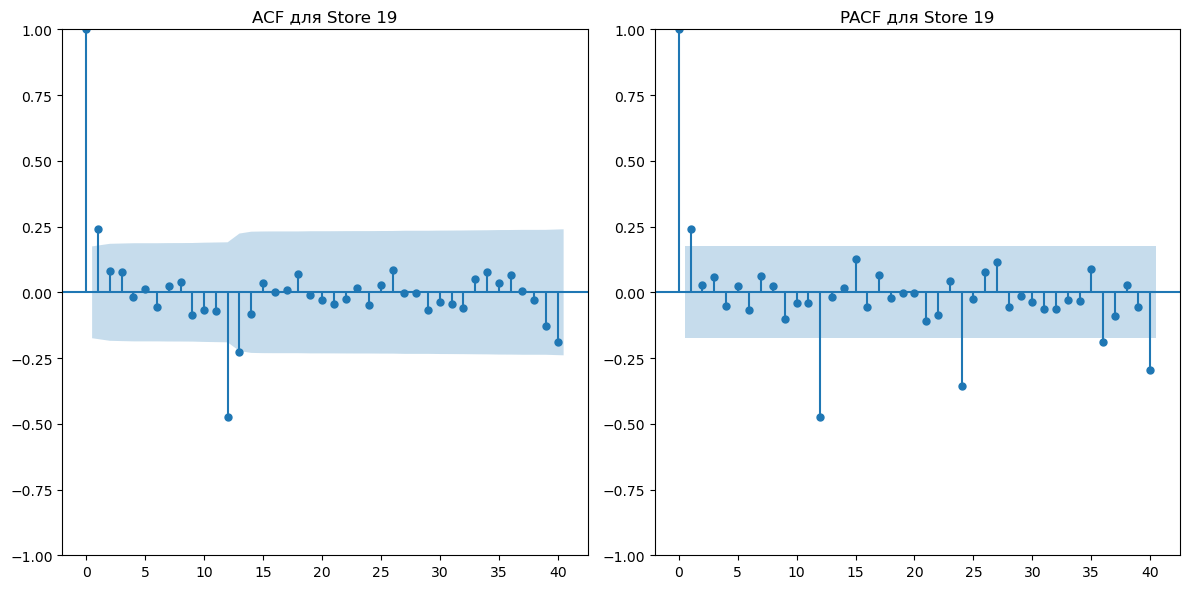

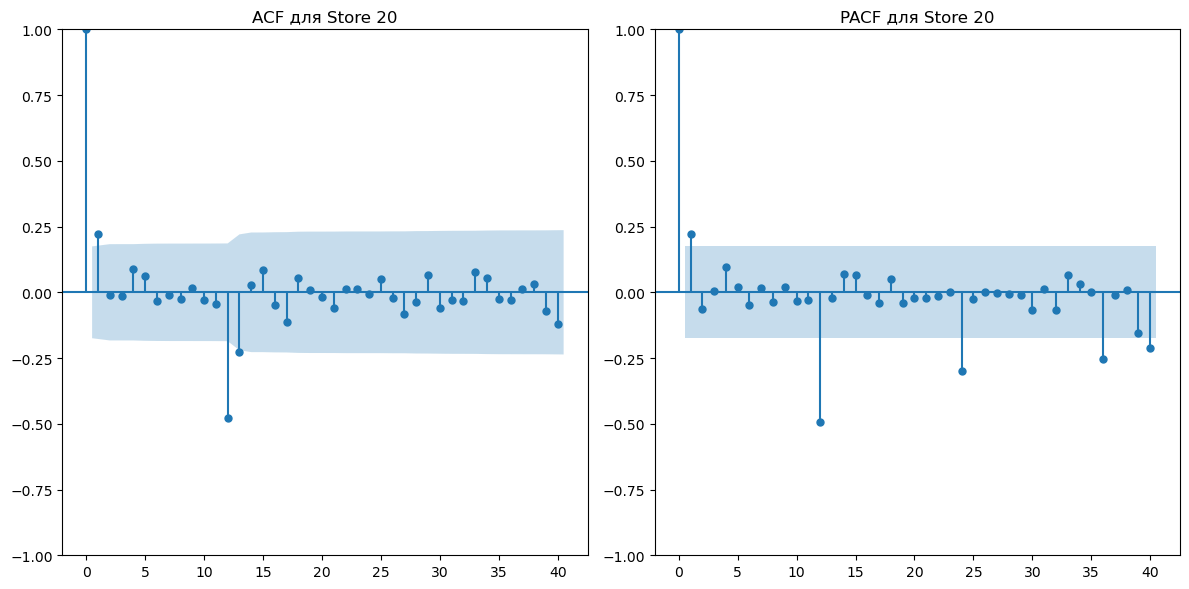

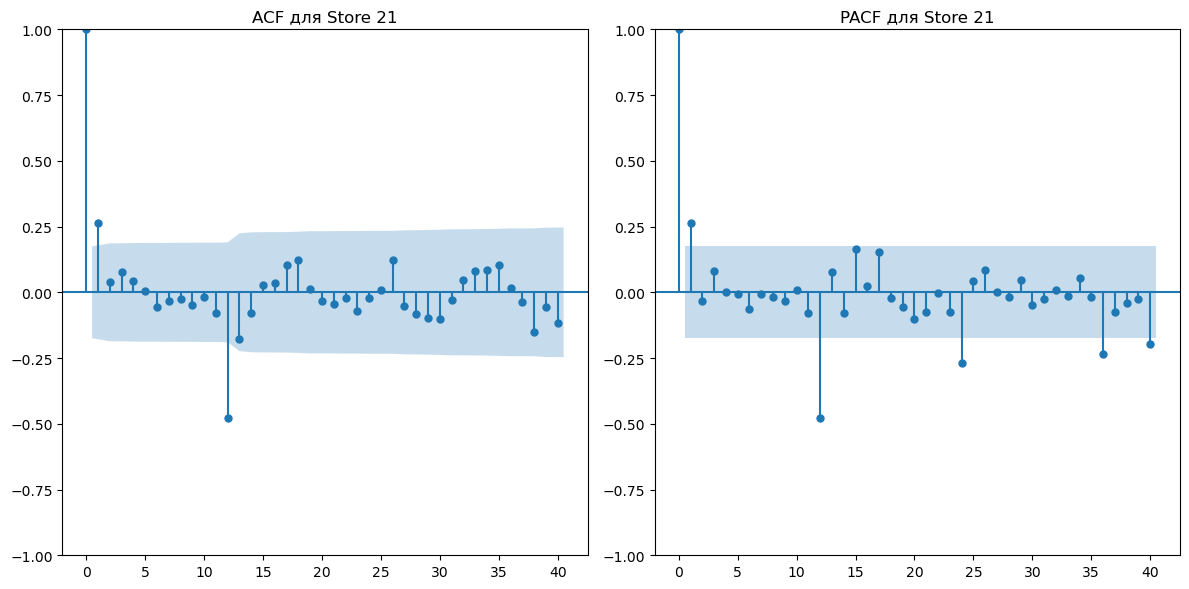

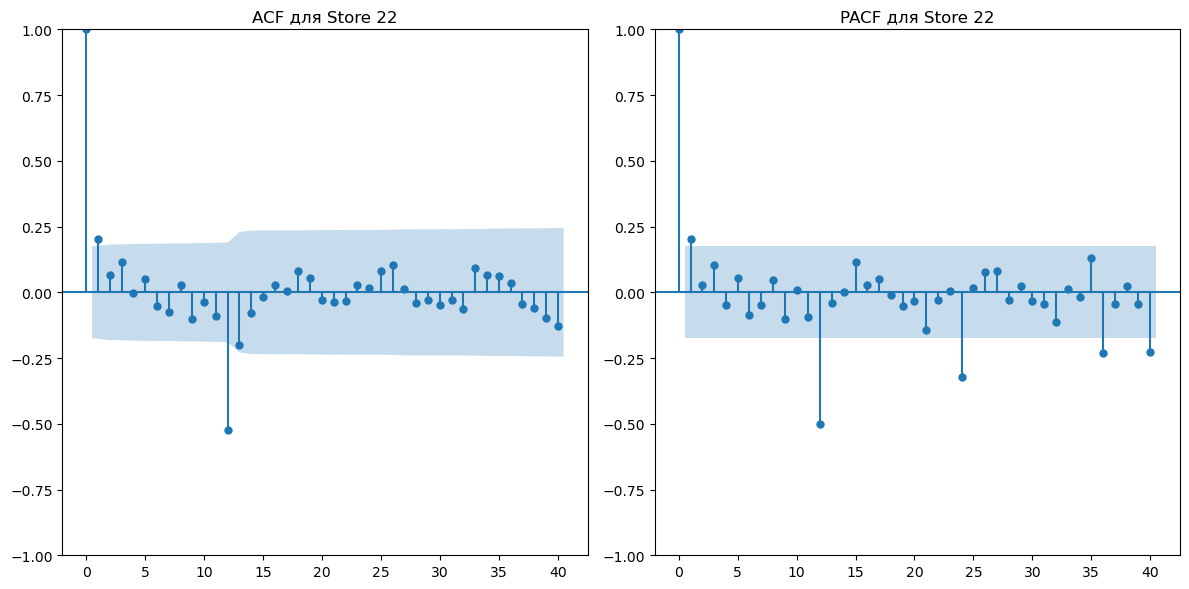

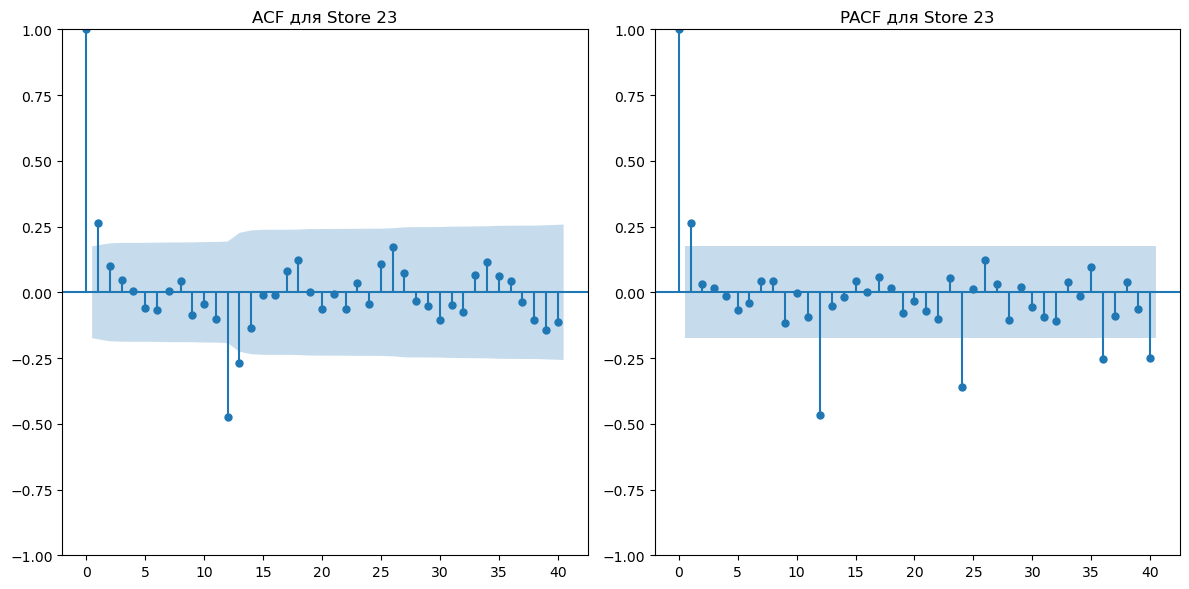

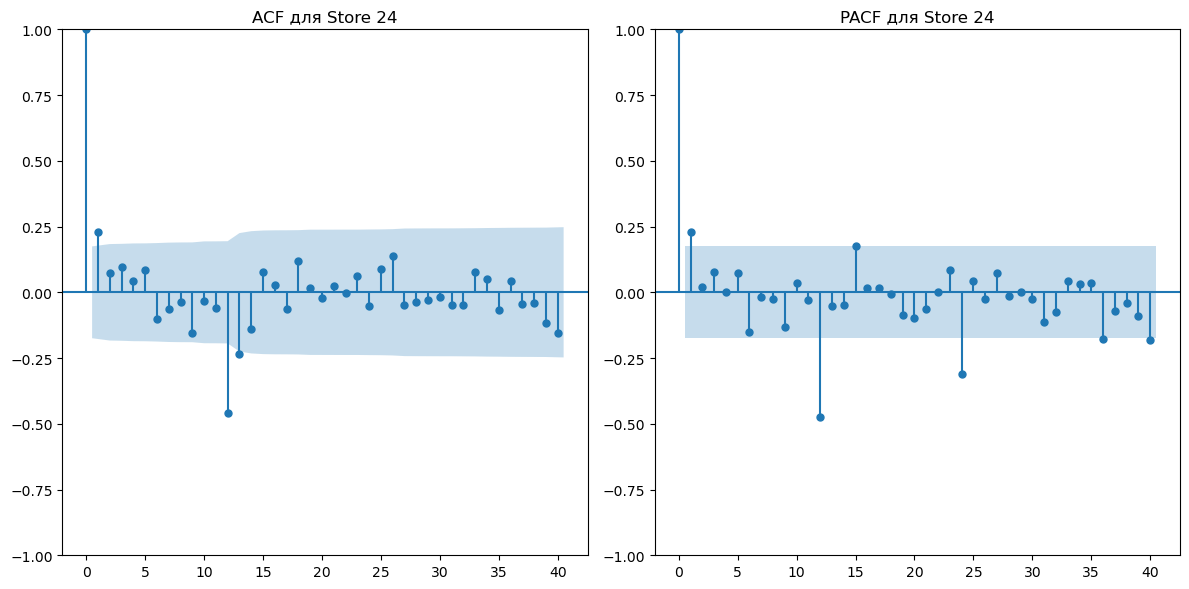

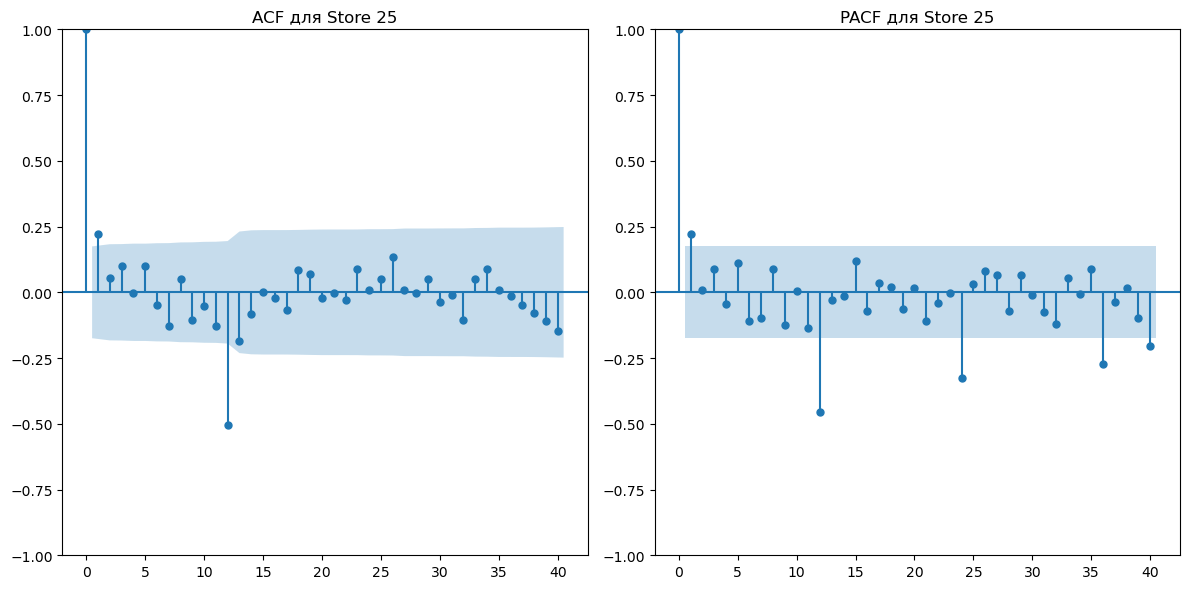

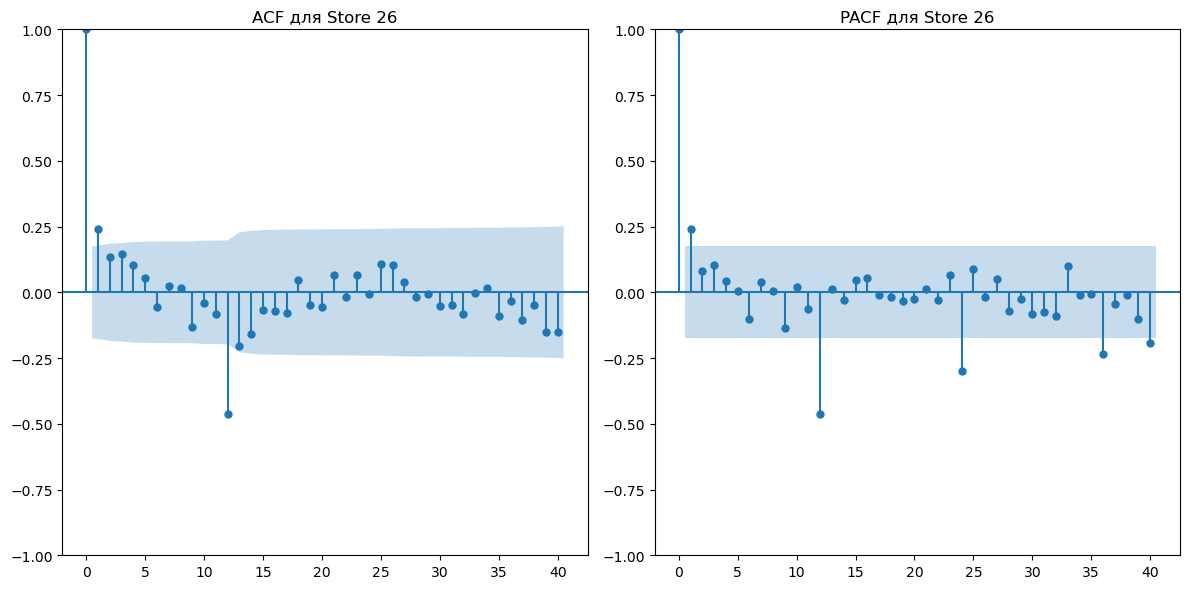

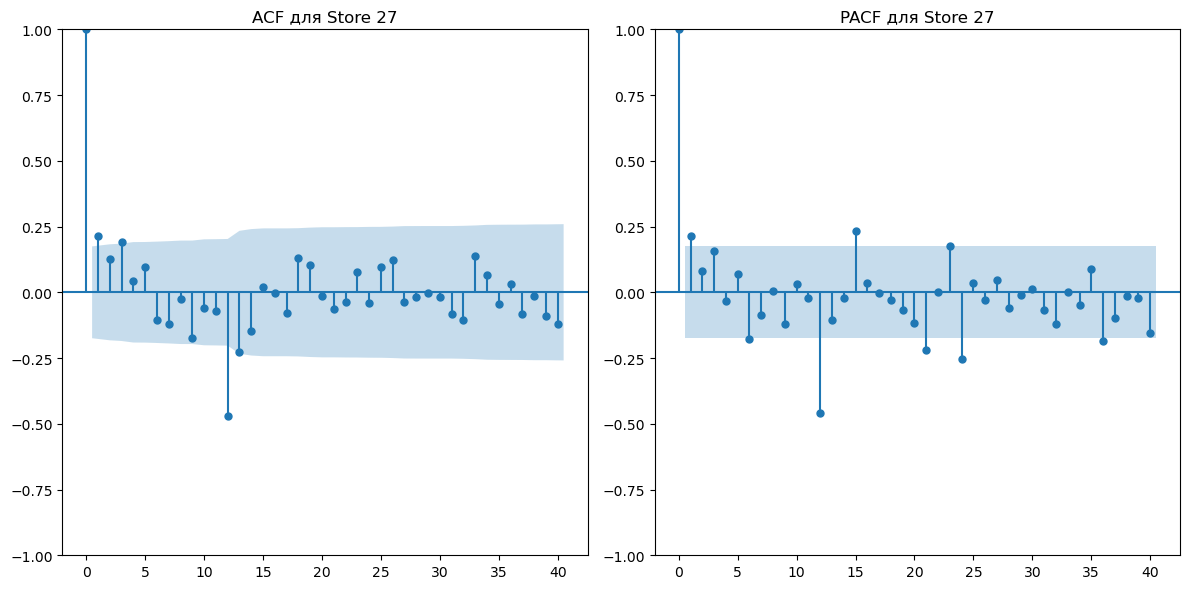

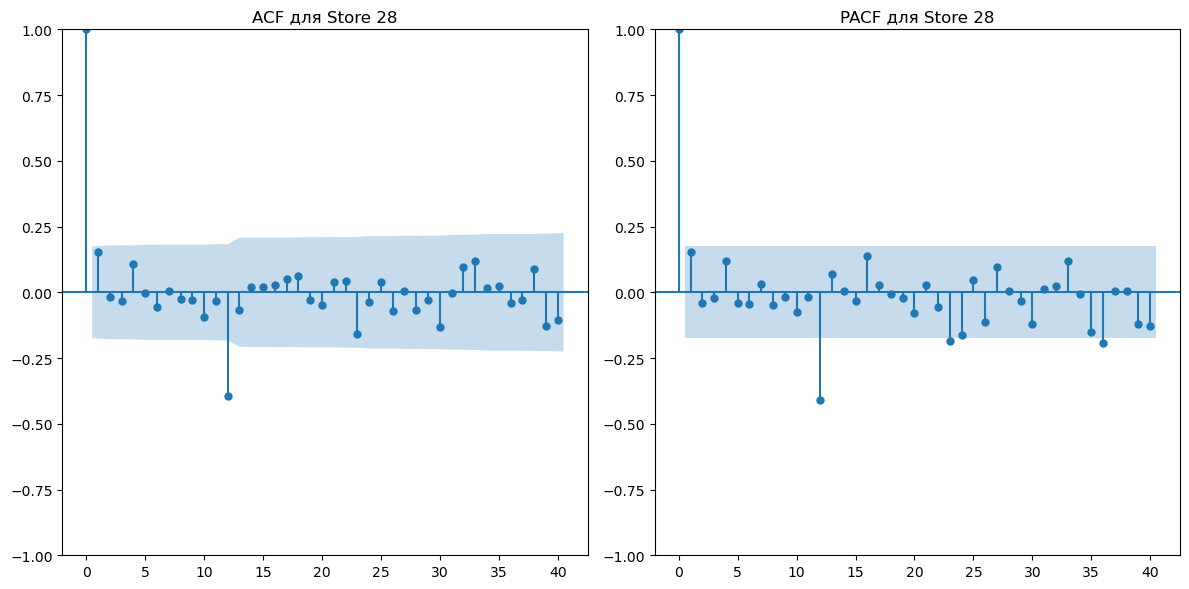

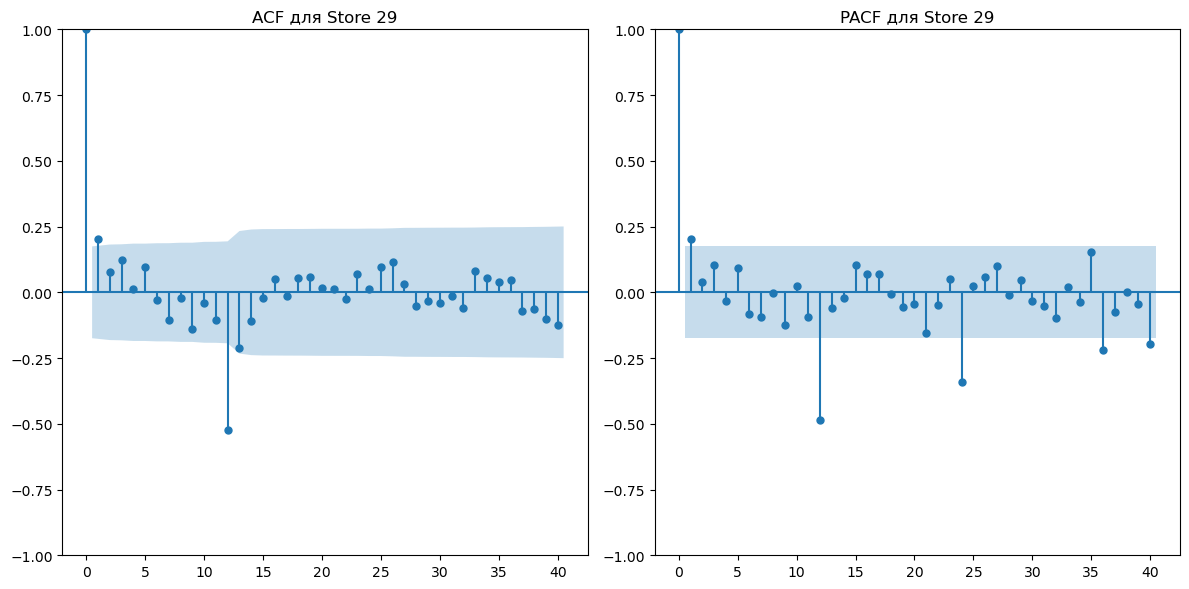

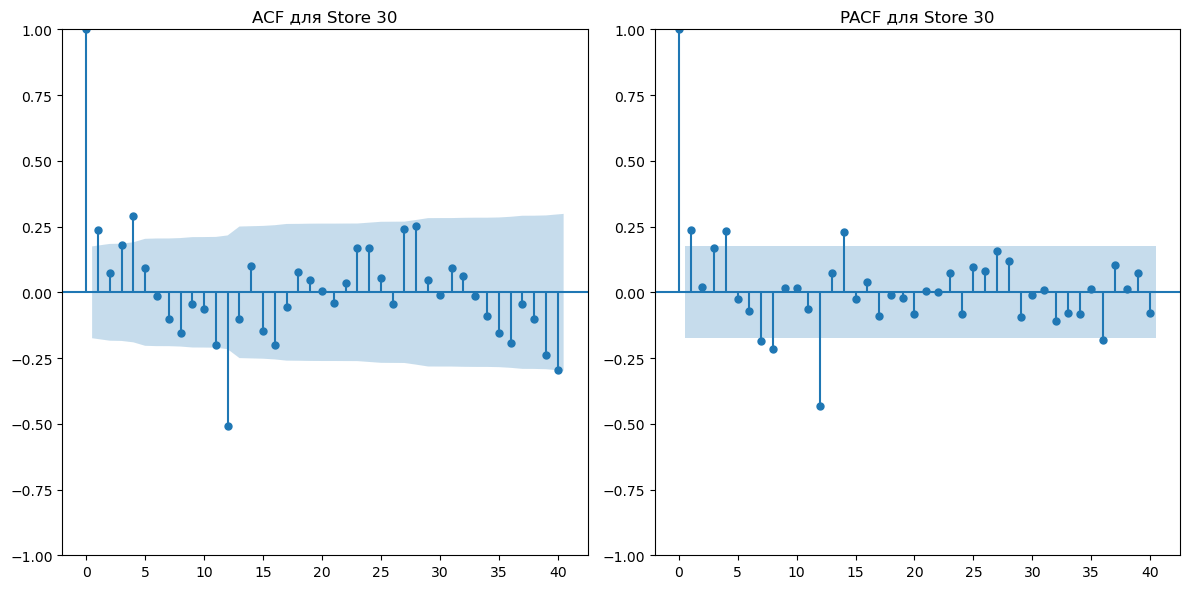

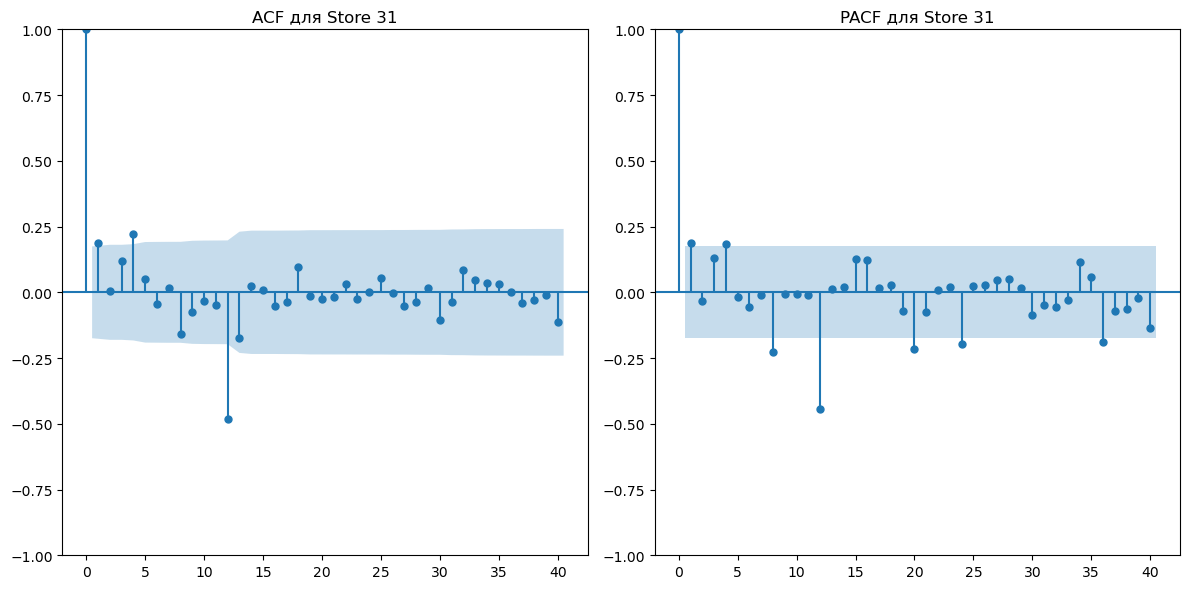

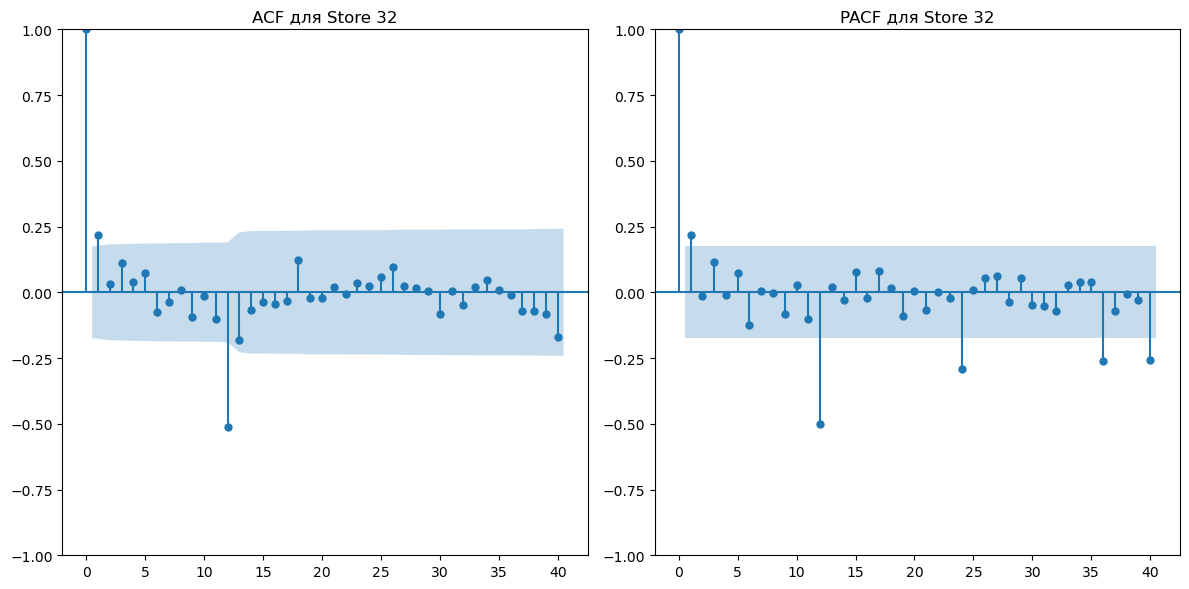

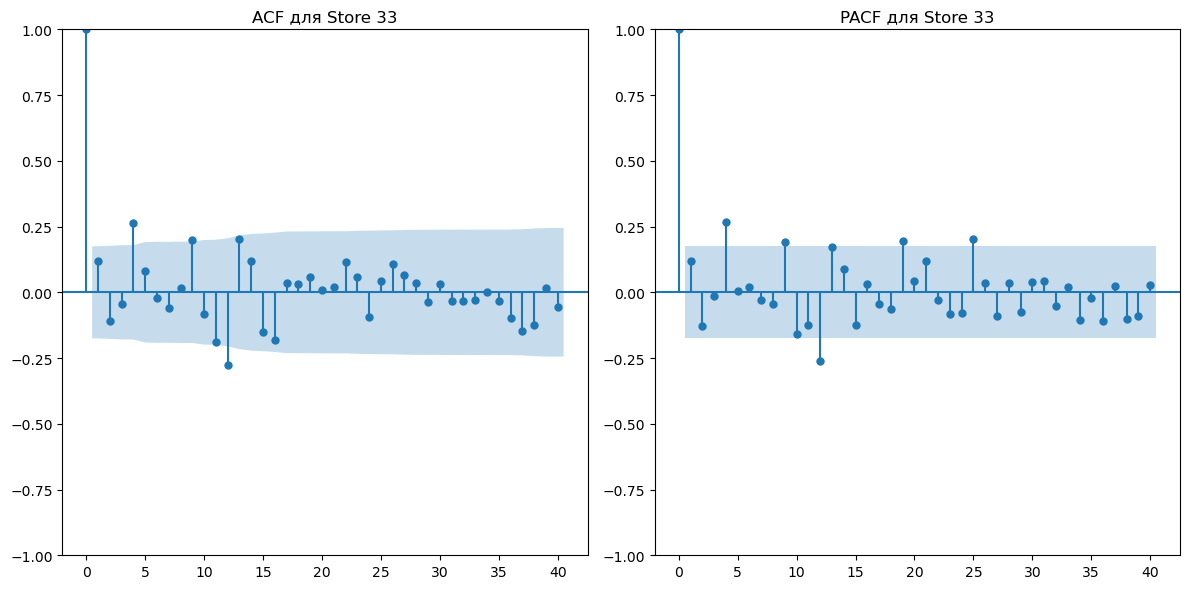

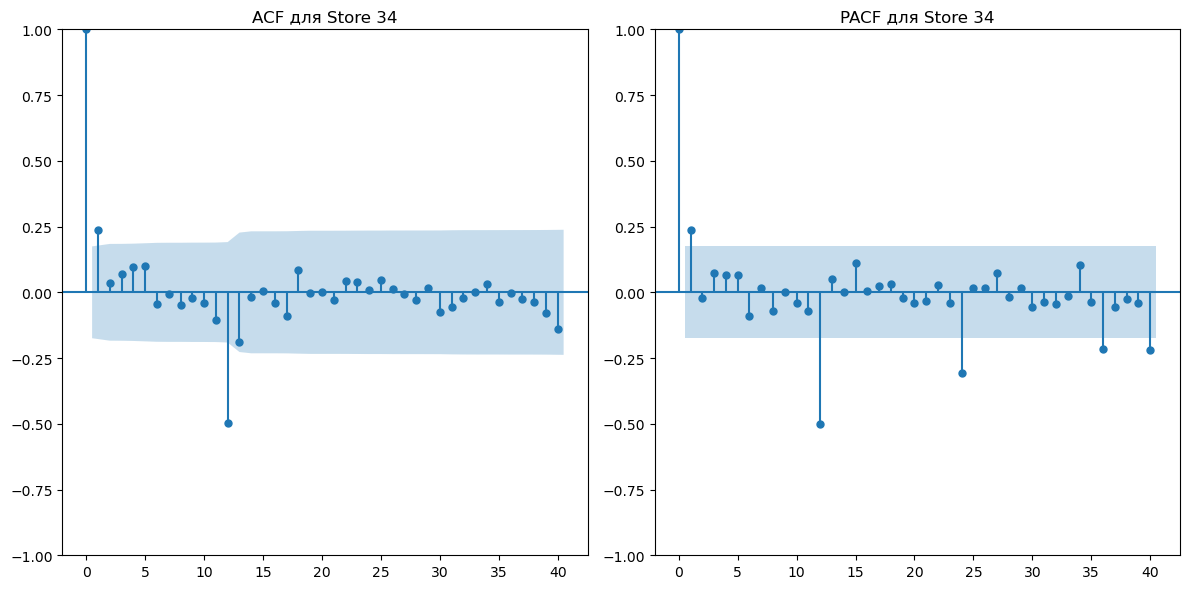

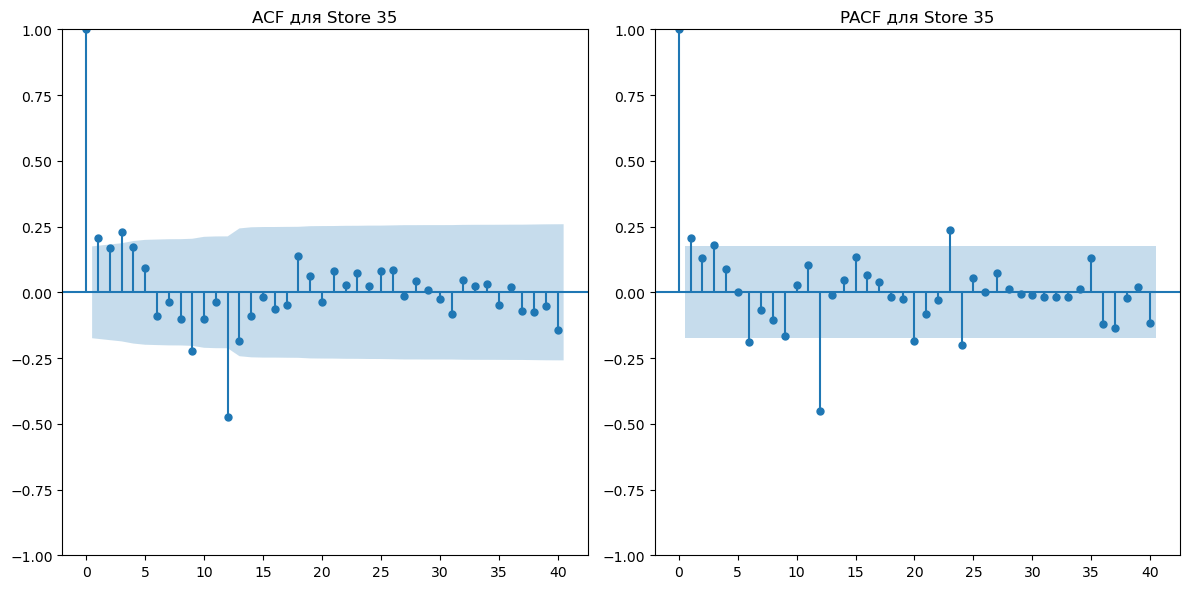

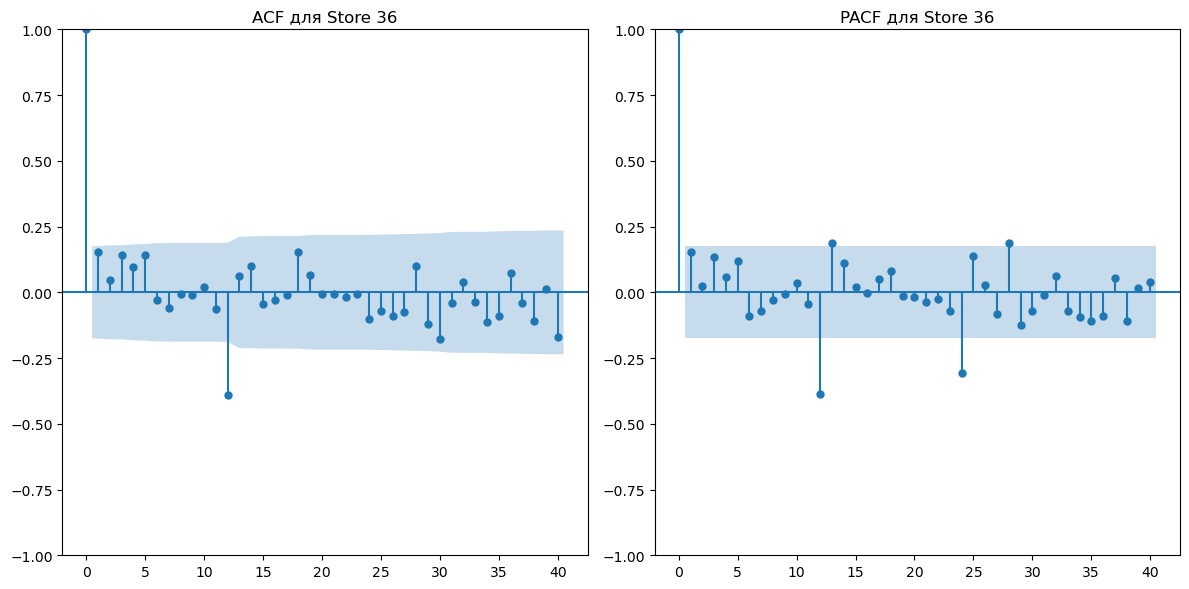

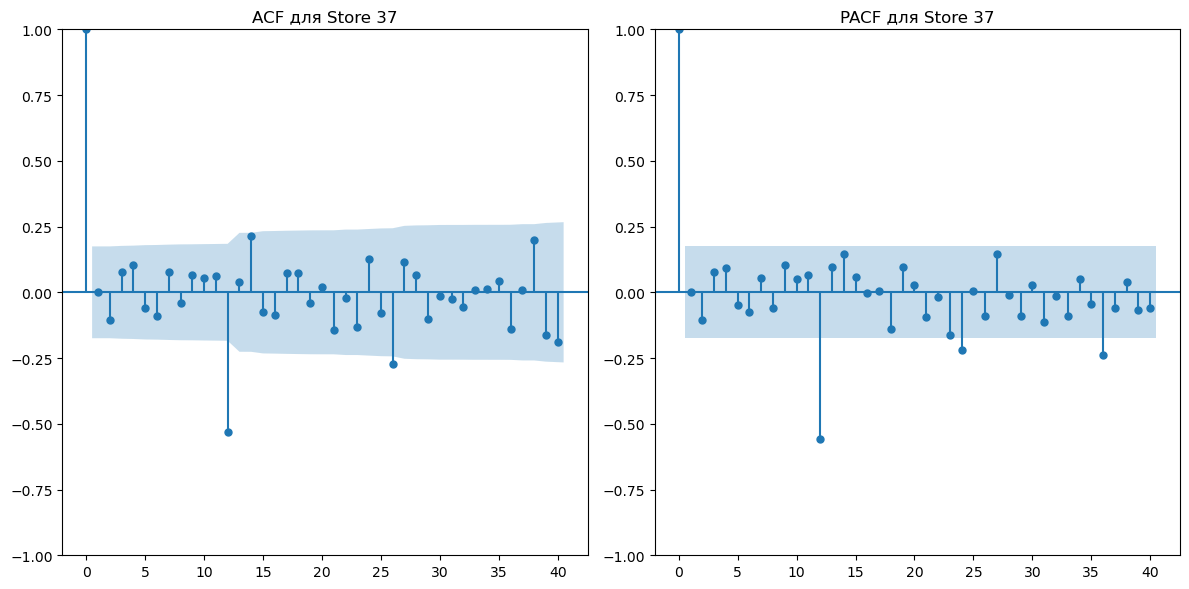

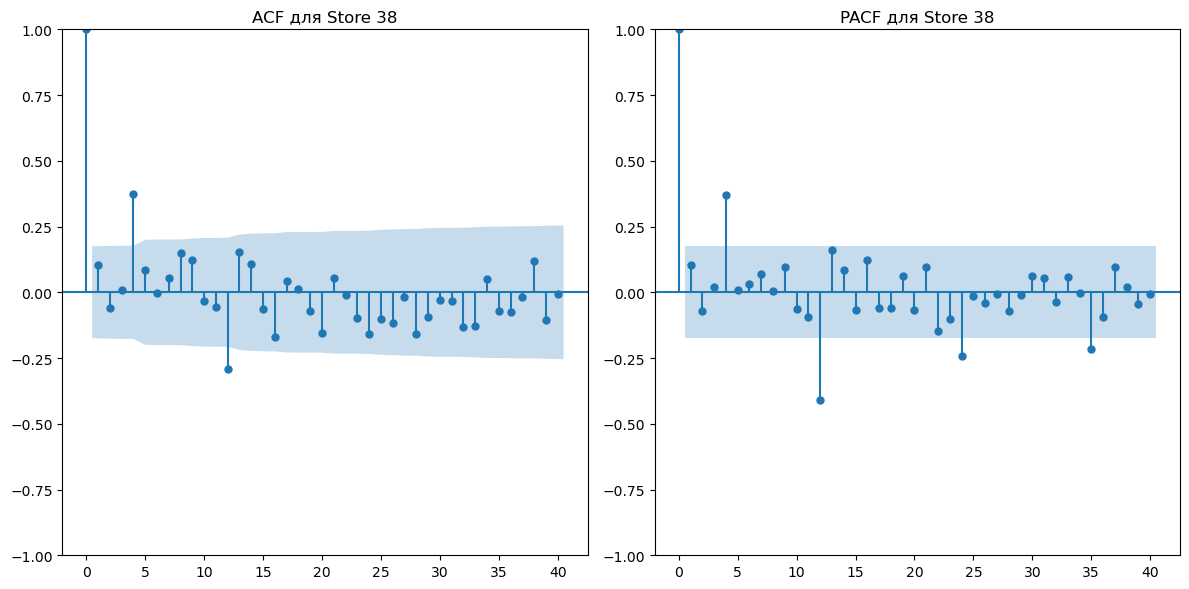

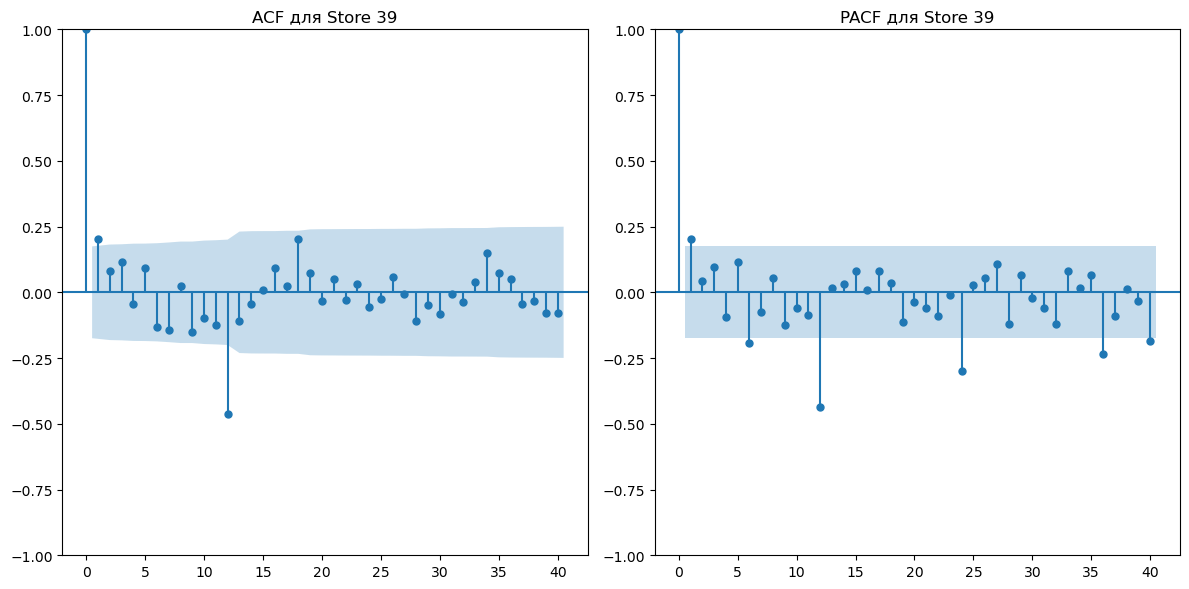

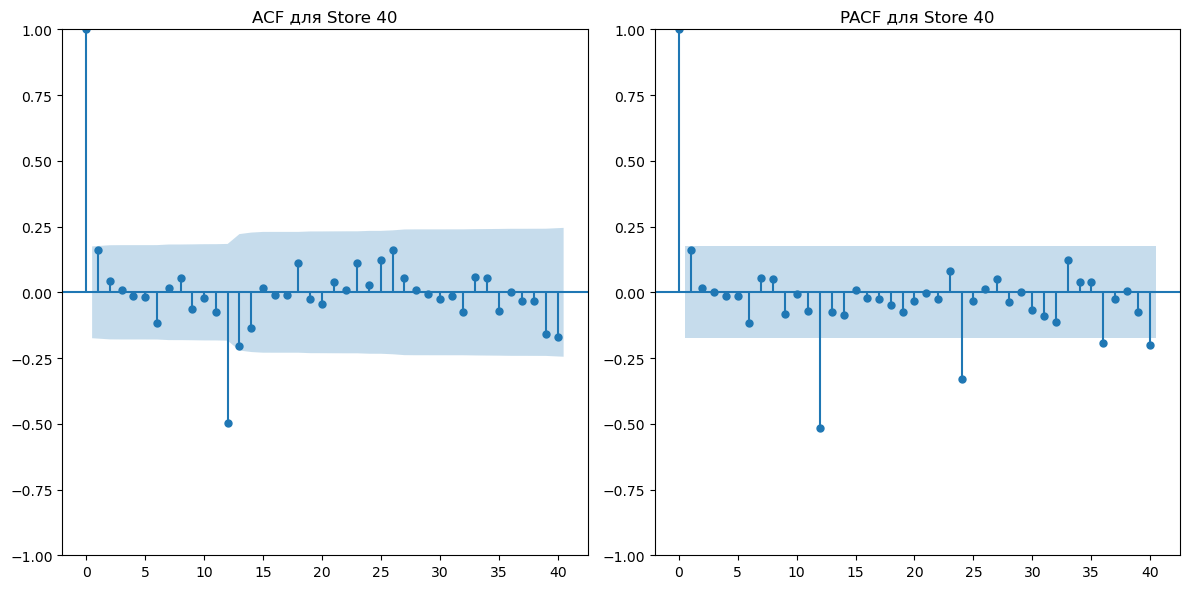

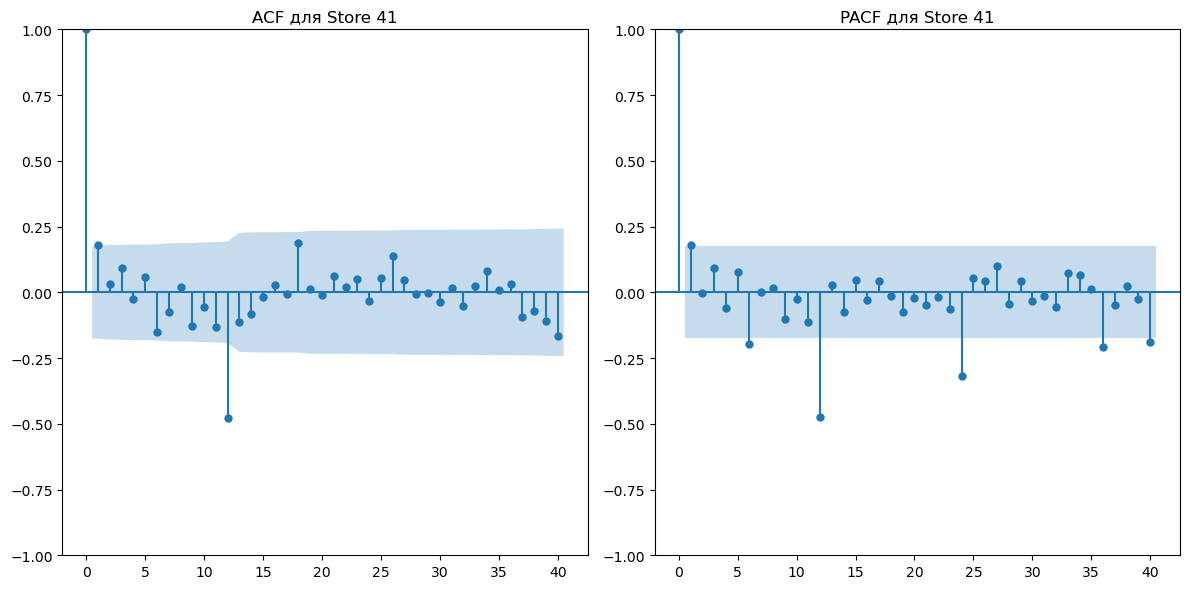

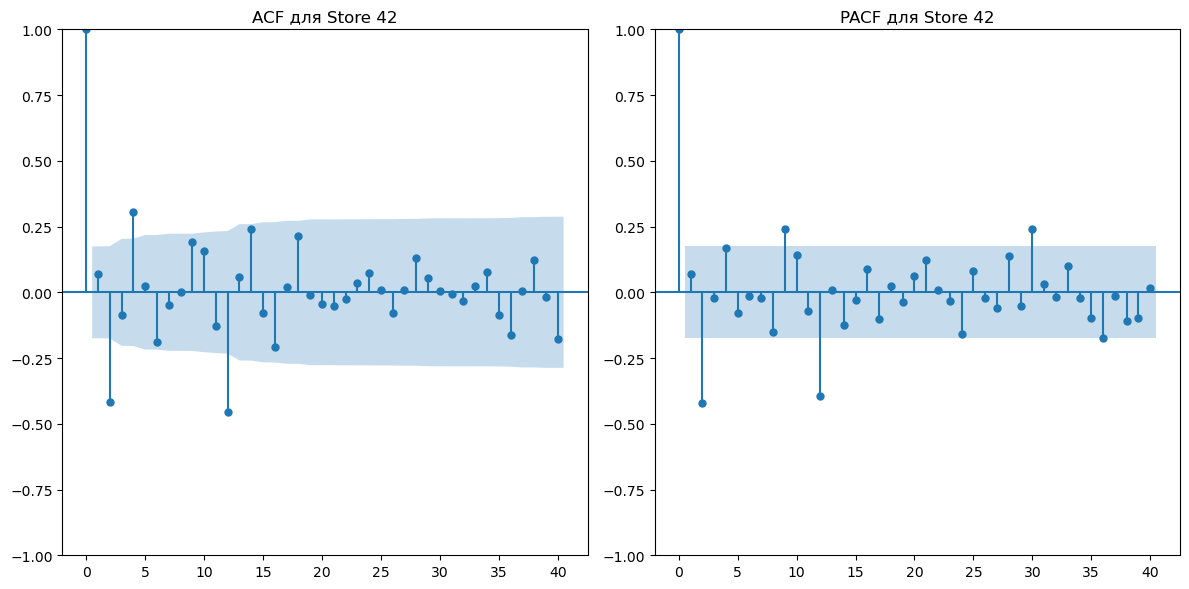

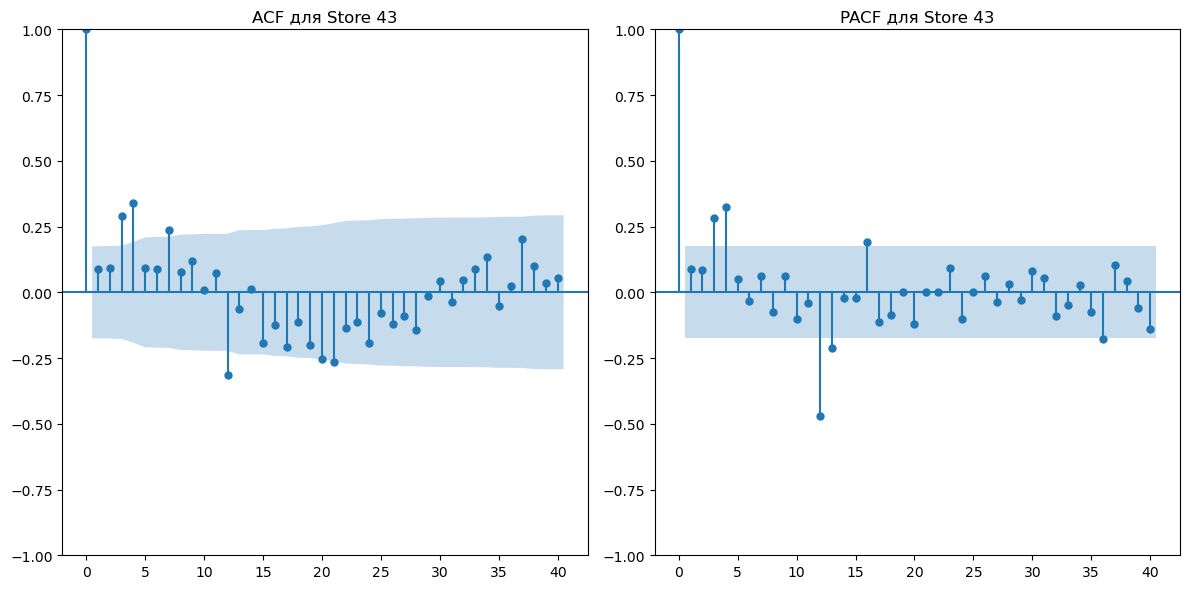

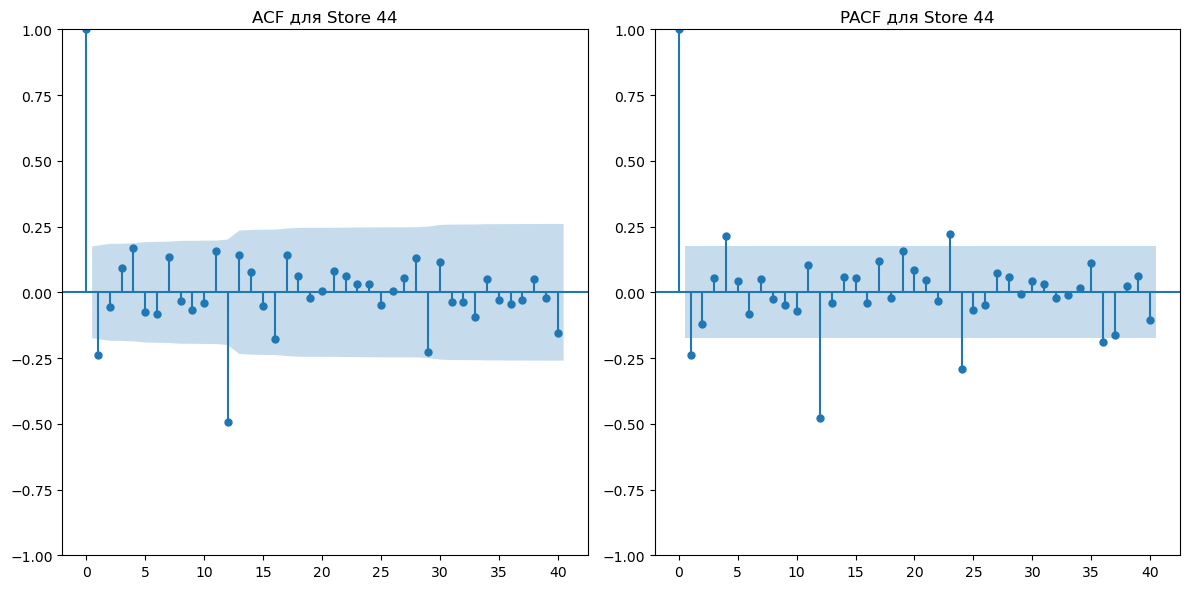

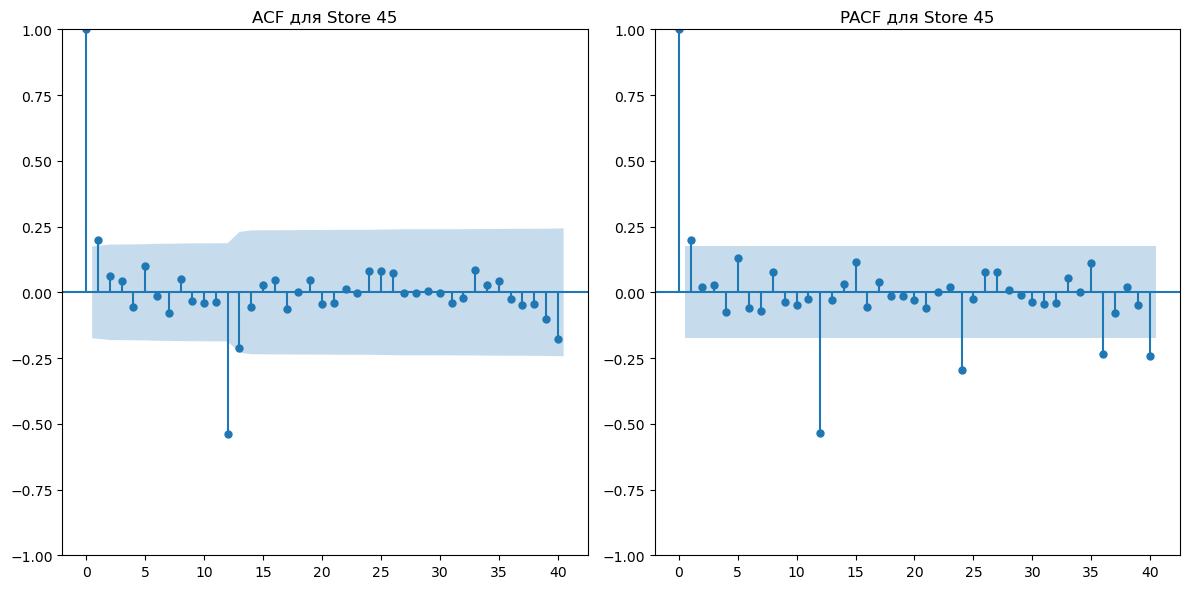

In [ ]:
stores = df['Store'].unique()

for store in stores:
    plt.figure(figsize=(12, 6))
    
    store_data = df[df['Store'] == store]['Weekly_Sales_seasonal_diff'][13:]
    
    plt.subplot(1, 2, 1)
    plot_acf(store_data, ax=plt.gca(), lags=40)
    plt.title(f'ACF для Store {store}')
    
    plt.subplot(1, 2, 2) 
    plot_pacf(store_data, ax=plt.gca(), lags=40)
    plt.title(f'PACF для Store {store}')
    
    plt.tight_layout()
    plt.show()

Далее я честно попытался обучить модель SARIMAX, но в зависимости от подобранных коэффициентов p, q и т.д. модель либо слишком долго обучалась, либо слишком плохо предсказывала (MAPE больше 30 процентов). Поэтому было принято решение исопользовать модель линейной регрессии, которая выдаёт MAPE 7% практически без какой-либо предварительной обработки данных.

Посмотрим на выбросы каждого магазина

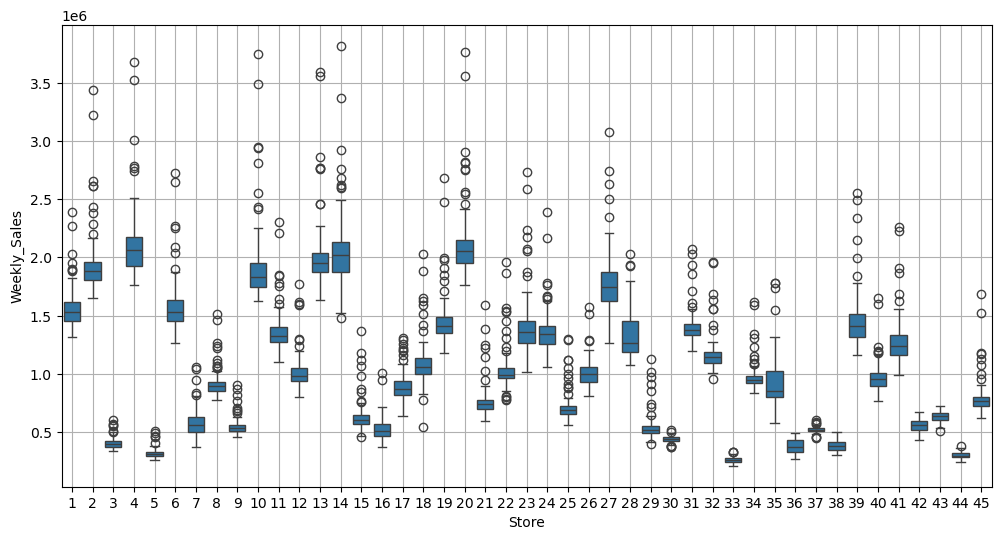

In [57]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=df)
plt.xlabel('Store')
plt.ylabel('Weekly_Sales')
plt.grid(True)
plt.show()

Очистим выбросы

In [85]:
def remove_outliers(df):
    lower_bound = df['Weekly_Sales'].quantile(0.1)
    upper_bound = df['Weekly_Sales'].quantile(0.9)
    return df[(df['Weekly_Sales'] >= lower_bound) & (df['Weekly_Sales'] <= upper_bound)]

df = df.groupby('Store', group_keys=False).apply(remove_outliers)

Смотрим результаты

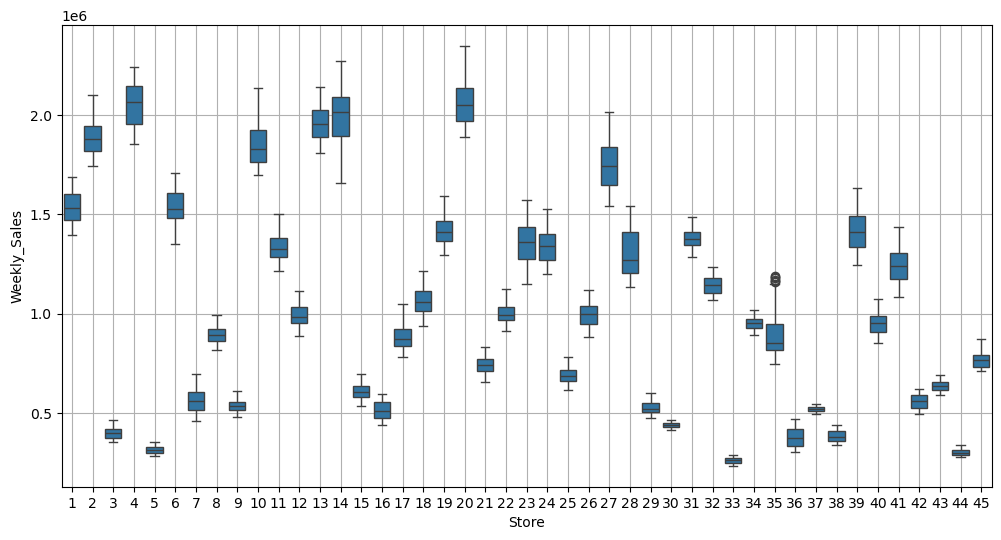

In [59]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=df)
plt.xlabel('Store')
plt.ylabel('Weekly_Sales')
plt.grid(True)
plt.show()

Теперь осталось только обучить модель

In [86]:
y_true = []
y_pred = []

models = {}

for store_id in df['Store'].unique():

    model = LinearRegression()

    models[store_id] = model

    store_data = df[df['Store'] == store_id]
    
    X = store_data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
    y = store_data['Weekly_Sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model.fit(X_train, y_train)
    
    prediction = model.predict(X_test)

    y_true.extend(y_test)
    y_pred.extend(prediction)

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"MAPE: {mape}")

MAPE: 0.04244425601596597


### Submit

In [87]:
predictions = []

for store_id, store_data in test_df.groupby('Store'):
    predictions.extend(models[store_id].predict(store_data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]))

data = {
    "source_attractiveness": predictions
}
submit = pd.DataFrame(data)
submit.to_csv('submission.csv', index_label="ID")